## Постановка Задачи

Одна из проблем компании Booking — это нечестные отели, которые накручивают себе рейтинг. \
Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. \
Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

Данные содержат следующие столбцы:

*   *hotel_address* — адрес отеля;
*   *review_date* — дата, когда рецензент разместил соответствующий отзыв;
*   *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
*   *hotel_name* — название отеля;
*   *reviewer_nationality* — национальность рецензента;
*   *negative_review* — отрицательный отзыв, который рецензент дал отелю;
*   *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;
*   *positive_review* — положительный отзыв, который рецензент дал отелю;
*   *review_total_positive_word_counts* — общее количество слов в положительном отзыве;
*   *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
*   *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
*   *total_number_of_reviews* — общее количество действительных отзывов об отеле;
*   *tags* — теги, которые рецензент дал отелю;
*   *days_since_review* — продолжительность между датой проверки и датой очистки;
*   *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв;
*   *lat* — широта отеля;
*   *lng* — долгота отеля.
  
Источник датасета: ["[SF-DST] Booking Reviews" (kaggle.com)](https://www.kaggle.com/competitions/sf-booking/data)

In [205]:
#import the standard libraries
import pandas as pd, numpy as np

#import the library for expressions
import re

#import the library for geocoding 
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

#import the library for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#import the library for statistical testing
import scipy.stats as stats
import statsmodels.api as sm

#import the library for visualization
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#import the library for encoding
import category_encoders
from sklearn import preprocessing
from sklearn.preprocessing import TargetEncoder

#import the library for spliting the data set
from sklearn.model_selection import train_test_split

#import the libraries for model testing
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [206]:
#set the file path
DATA_DIR = '/Users/victoriavilicheva/Documents/PYTHON/BLOCK-3/PROJECT-3 - SUBMISSION/data'

#import the data set
train_hotels = pd.read_csv(DATA_DIR+'/hotels_train.csv')
test_hotels = pd.read_csv(DATA_DIR+'/hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

In [207]:
#create a a new feature to differentiate between two data sets
train_hotels['sample'] = 1
test_hotels['sample'] = 0

#score to be predicted thus set to 0
test_hotels['reviewer_score'] = 0

In [208]:
#concatenate train and test 
hotels_orig = pd.concat([train_hotels, test_hotels], ignore_index=True).reset_index(drop=True)

In [209]:
#check the data set was imported correctly
hotels_orig.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1


### Описательный Анализ Данных

In [210]:
print(f'Размер таблицы: {hotels_orig.shape}')

Размер таблицы: (515738, 18)


In [211]:
#find the columns
list(hotels_orig)

['hotel_address',
 'additional_number_of_scoring',
 'review_date',
 'average_score',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'positive_review',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'tags',
 'days_since_review',
 'lat',
 'lng',
 'sample']

In [212]:
#basic information about the data set
hotels_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Преобразование Данных

Проверим данные на наличие пропусков:

In [213]:
#check that there are no null values in the data set
hotels_orig.isnull().sum()[hotels_orig.isnull().sum() > 0]

lat    3268
lng    3268
dtype: int64

In [214]:
#fill the null values with 0
hotels_orig['lat'] = hotels_orig['lat'].fillna(0)
hotels_orig['lng'] = hotels_orig['lng'].fillna(0)

Не работаем с дубликатами, так как *ValueError: length of values does not match length of index*.

##### Создание новых признаков - city и country:

In [215]:
#create a column with elements separated
hotels_orig['separate_address'] = hotels_orig['hotel_address'].str.split()

In [216]:
#create a column taking the last element
hotels_orig['one'] = hotels_orig['separate_address'].apply(lambda x: x[-1])

In [217]:
#check that the result is a country name
hotels_orig['one'].value_counts()

one
Kingdom        262301
Spain           60149
France          59928
Netherlands     57214
Austria         38939
Italy           37207
Name: count, dtype: int64

In [218]:
#create a column taking the element for city
hotels_orig['city'] = hotels_orig['separate_address'].apply(lambda x: x[-2] if (x[-1] != 'Kingdom') else x[-5])

In [219]:
#check that the result is a city name
hotels_orig['city'].value_counts()

city
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: count, dtype: int64

In [220]:
#create a function to fix the country
def convert_country(x):
    #complete the country name
    if x['one'] == 'Kingdom':
        return 'United Kingdom'
    #for all other conditions
    else:
        return x['one']

#create a new column by applying the function
hotels_orig['country'] = hotels_orig.apply(convert_country, axis=1)

##### Создание нового признака - citizen:

Удаление пробелов в начале и конце:

In [221]:
#the beginning of the string
hotels_orig.reviewer_nationality = hotels_orig.reviewer_nationality.replace('^\s+', '', regex=True)

#the end of the string
hotels_orig.reviewer_nationality = hotels_orig.reviewer_nationality.replace('\s+$', '', regex=True)

In [222]:
#create a function to find whether the reviewer is a citizen where the hotel is located
def find_citizenship(x):
    if x['country'] == x['reviewer_nationality']:
        return 1
    else:
        return 0

#create a new column by applying the function
hotels_orig['citizen'] = hotels_orig.apply(find_citizenship, axis=1)

Кодировка признаков - country и city:

In [223]:
#categorise both country and city
hotels_orig['country_code'] = hotels_orig['country'].astype('category').cat.codes
hotels_orig['city_code'] = hotels_orig['country'].astype('category').cat.codes

##### Кодировка признака - reviewer_nationality:

In [224]:
#check the citizenship of the reviewer
hotels_orig['reviewer_nationality'].value_counts().nunique()

148

In [225]:
#find top 50
round(hotels_orig['reviewer_nationality'].value_counts(normalize=True).nlargest(50) * 100, 2)[:5]

reviewer_nationality
United Kingdom              47.55
United States of America     6.87
Australia                    4.20
Ireland                      2.87
United Arab Emirates         1.98
Name: proportion, dtype: float64

In [226]:
#engineer the feature to keep only top 50 known nationalities
top_50 = hotels_orig['reviewer_nationality'].value_counts().nlargest(50).index
hotels_orig['reviewer_nationality'] = hotels_orig['reviewer_nationality'].apply(lambda x: x if x in top_50 else 'Other')

In [227]:
#confirm the change
round(hotels_orig['reviewer_nationality'].value_counts(normalize=True) * 100, 2)[:5]

reviewer_nationality
United Kingdom              47.55
United States of America     6.87
Other                        5.09
Australia                    4.20
Ireland                      2.87
Name: proportion, dtype: float64

In [228]:
#categorise reviewer nationality
hotels_orig['reviewer_nationality_code'] = hotels_orig['reviewer_nationality'].astype('category').cat.codes

#confirm the result
hotels_orig['reviewer_nationality_code'].value_counts().nunique()

51

##### Создание нового признака - distance:

Найти [координаты](https://www.latlong.net/place/london-uk-14153.html)

In [229]:
#create a new dataframe with centre location coordinates of major cities
city_centre_coordinates = pd.DataFrame({
    'city': ['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan'],
    'ctr_lat': [51.509865, 41.390205, 48.864716, 52.377956, 48.210033, 45.464664],
    'ctr_lng': [-0.118092, 2.154007, 2.349014, 4.897070, 16.363449, 9.188540]
})
city_centre_coordinates

,city,ctr_lat,ctr_lng
0,London,51.509865,-0.118092
1,Barcelona,41.390205,2.154007
2,Paris,48.864716,2.349014
3,Amsterdam,52.377956,4.897070
4,Vienna,48.210033,16.363449
5,Milan,45.464664,9.188540


In [230]:
#merge two dataframes together
hotels_new = hotels_orig.merge(city_centre_coordinates,
                               how='inner',
                               on='city')

hotels_new.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,separate_address,one,city,country,citizen,country_code,city_code,reviewer_nationality_code,ctr_lat,ctr_lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,"[Stratton, Street, Mayfair, Westminster, Borou...",Kingdom,London,United Kingdom,1,5,5,49,51.509865,-0.118092
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,"[130, 134, Southampton, Row, Camden, London, W...",Kingdom,London,United Kingdom,1,5,5,49,51.509865,-0.118092


In [231]:
#find the outliers by the hotel address
print(hotels_new[hotels_new['lat'] == 0][['hotel_address', 'hotel_name']].value_counts())
print()

print(hotels_new[hotels_new['lat'] == 0][['hotel_address', 'hotel_name']].value_counts().sum())

hotel_address                                                hotel_name                                      
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria  Fleming s Selection Hotel Wien City                 658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria          Hotel City Central                                  563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria     Hotel Atlanta                                       389
4 rue de la P pini re 8th arr 75008 Paris France             Maison Albar Hotel Paris Op ra Diamond              290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria       Hotel Daniel Vienna                                 245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria        Hotel Pension Baron am Schottentor                  223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria             Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria          Derag Livi

In [232]:
#create a subset of the dataset with key features
missing = hotels_new[hotels_new['lat'] == 0][['hotel_address', 'separate_address', 'country']]
missing

,hotel_address,separate_address,country
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,"[Savoyenstra, e, 2, 16, Ottakring, 1160, Vienn...",Austria
566,23 Rue Damr mont 18th arr 75018 Paris France,"[23, Rue, Damr, mont, 18th, arr, 75018, Paris,...",France
724,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,"[Josefst, dter, Stra, e, 10, 12, 08, Josefstad...",Austria
754,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,"[W, hringer, Stra, e, 33, 35, 09, Alsergrund, ...",Austria
1137,4 rue de la P pini re 8th arr 75008 Paris France,"[4, rue, de, la, P, pini, re, 8th, arr, 75008,...",France
...,...,...,...
515042,4 rue de la P pini re 8th arr 75008 Paris France,"[4, rue, de, la, P, pini, re, 8th, arr, 75008,...",France
515133,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,"[Sieveringer, Stra, e, 4, 19, D, bling, 1190, ...",Austria
515273,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,"[Landstra, er, G, rtel, 5, 03, Landstra, e, 10...",Austria
515600,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,"[Savoyenstra, e, 2, 16, Ottakring, 1160, Vienn...",Austria


In [233]:
#find the geocode based on the hotel address
missing['geocode'] = missing['separate_address'].apply(lambda x: x[-3])

Поиск координат вручную:

In [234]:
geolocator = Nominatim(user_agent='SF_agent')
hotel_address = [('08009', 'Spain'), ('08010', 'Spain'), ('08011', 'Spain'),
                 (1020, 'Vienna', 'Austria'), (1030, 'Austria'), (1080, 'Vienna', 'Austria'),
                 (1090, 'Vienna', 'Austria'), (1110, 'Austria'), (1160, 'Austria'), (1190, 'Austria'),
                 (75008, 'France'), (75014, 'France'), (75018, 'France')]

except_ = True

missing_coordinates = []
while except_:
    try:
        except_ = False
        for x in hotel_address:
            location = geolocator.geocode(x)
            missing_coordinates.append([round(location.latitude, 6), round(location.longitude, 6)])
    except:
        except_ = True

missing_coordinates

[[41.394782, 2.169299],
 [41.391504, 2.174635],
 [41.384387, 2.158965],
 [48.208354, 16.372504],
 [48.193644, 16.396286],
 [48.208354, 16.372504],
 [48.208354, 16.372504],
 [48.163109, 16.458013],
 [48.214955, 16.302153],
 [48.261251, 16.328471],
 [48.873265, 2.311162],
 [48.829567, 2.323962],
 [48.892132, 2.348179]]

In [235]:
#create a new dataframe with missing geolocation
location_by_code = pd.DataFrame({
    'geocode': ['08009', '08010', '08011', #Spain
                '1020', '1030', '1080', '1090', '1110', '1160', '1190', #Austria
                '75008', '75014', '75018'], #France
    'm_lat': [41.394782, 41.391504, 41.384375,
              48.208354, 48.193644, 48.208354, 48.208354, 48.163109, 48.214955, 48.261251,
              48.873265, 48.829567, 48.892132],
    'm_lng': [2.169299, 2.174635, 2.158984,
              16.372504, 16.396286, 16.372504, 16.372504, 16.458013, 16.302153, 16.328471,
              2.311162, 2.323962, 2.348179]
})

location_by_code

,geocode,m_lat,m_lng
0,08009,41.394782,2.169299
1,08010,41.391504,2.174635
2,08011,41.384375,2.158984
3,1020,48.208354,16.372504
4,1030,48.193644,16.396286
5,1080,48.208354,16.372504
6,1090,48.208354,16.372504
7,1110,48.163109,16.458013
8,1160,48.214955,16.302153
9,1190,48.261251,16.328471


In [236]:
#find the geocode based on the hotel address for the main dataset
hotels_new['geocode'] = hotels_new['separate_address'].apply(lambda x: x[-3])

In [237]:
#merge two dataframes by geocode
hotels = pd.merge(hotels_new, location_by_code, on='geocode', how='outer')

In [238]:
#replace null (0) values with new coordinates, otherwise keep the old details
hotels['cor_lat'] = np.where(hotels['lat'] == 0, hotels['m_lat'], hotels['lat'])
hotels['cor_lng'] = np.where(hotels['lng'] == 0, hotels['m_lng'], hotels['lng'])

Вычислить расстояние: \
Длина кратчайшего пути между двумя точками на любой поверхности.

In [239]:
#write a function to calculate the distance between two points on the surface of a spheroid (vincenty's formula)
def calculate_distance(arg):
    #import the city centre coordinates
    x, y = arg['ctr_lat'], arg['ctr_lng']
    
    #import the hotel coordinates
    i, j = arg['cor_lat'], arg['cor_lng']
    
    #create the calculation variables
    city_centre = (x, y)
    hotel_location = (i, j)
    
    #return the distance in km
    return geodesic(city_centre, hotel_location).km

#create a new feature - distance in km - by applying the function
hotels['distance'] = hotels.apply(calculate_distance, axis=1)

In [240]:
#check for outliers
hotels['distance'].describe()

count    515738.000000
mean          3.269263
std           2.582423
min           0.023718
25%           1.409770
50%           2.538532
75%           4.465126
max          17.793405
Name: distance, dtype: float64

In [241]:
#categorize distance
distance_conditions = [hotels['distance'] < 0.5,
                       hotels['distance'].between(0.5, 1),
                       hotels['distance'].between(1, 1.5),
                       hotels['distance'].between(1.5, 2),
                       hotels['distance'].between(2, 3),
                       hotels['distance'].between(3, 5),
                       hotels['distance'].between(5, 10),
                       hotels['distance'] >= 10]

distance_category = ['<0.5KM', '0.5-1KM', '1-1.5KM', '1.5-2KM', '2-3KM', '3-5KM', '5-10KM', '>10KM']

hotels['c_distance'] = np.select(distance_conditions, distance_category)

In [242]:
#categorise distance numerically
hotels['distance_n'] = hotels['c_distance'].astype('category').cat.codes

##### Кодировка признака - hotel_name:

In [243]:
#find the unique hotel names
hotels['hotel_name'].nunique()

1492

In [244]:
#categorise distance numerically
hotels['hotel_name'] = hotels['hotel_name'].astype('category')
hotels['hotel_name_n'] = hotels['hotel_name'].cat.codes

In [245]:
#drop unnecessary features
hotels = hotels.drop(['hotel_address', 'hotel_name', 'reviewer_nationality', 'separate_address', 'one',
                      'lat', 'lng', 'ctr_lat', 'ctr_lng', 'geocode', 'm_lat', 'm_lng', 'cor_lat', 'cor_lng'],
                     axis=1, errors='ignore')

##### Преобразование признаков - tags:

In [246]:
#separate the elements
hotels['tags_count'] = hotels['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))

#find the total number of elements
hotels['tags_count'].unique()

array([4, 5, 6, 3, 2, 1])

In [247]:
#separate the elements
hotels['sep_tags'] = hotels['tags'].str.replace('[', '').str.replace(']', '').str.replace("'", '')

In [248]:
#check the content of the tag
print(hotels[(hotels['tags_count'] == 5)]['sep_tags'].iloc[0])
print(hotels[(hotels['tags_count'] == 4)]['sep_tags'].iloc[4])

 Leisure trip ,  Group ,  Superior Double or Twin Room ,  Stayed 4 nights ,  Submitted from a mobile device 
 Leisure trip ,  Couple ,  Double or Twin Room ,  Stayed 4 nights 


In [249]:
#separate the tags into specific elements
hotels['purpose'] = hotels.sep_tags.str.split(',').str[0]
hotels['traveler'] = hotels.sep_tags.str.split(',').str[1]
hotels['room'] = hotels.sep_tags.str.split(',').str[2]
hotels['duration'] = hotels.sep_tags.str.split(',').str[3]

#two additional features needed
hotels['add1'] = hotels.sep_tags.str.split(',').str[4]
hotels['add2'] = hotels.sep_tags.str.split(',').str[-1]

In [250]:
#check that there are no null values in the data set
hotels.isnull().sum()[hotels.isnull().sum() > 0]

traveler         6
room            91
duration      5596
add1        217160
dtype: int64

Удаление пробелов в начале и конце:

In [251]:
#the beginning of the string
hotels.purpose = hotels.purpose.replace('^\s+', '', regex=True)
hotels.traveler = hotels.traveler.replace('^\s+', '', regex=True)
hotels.room = hotels.room.replace('^\s+', '', regex=True)
hotels.duration = hotels.duration.replace('^\s+', '', regex=True)
hotels.add1 = hotels.add1.replace('^\s+', '', regex=True)
hotels.add2 = hotels.add2.replace('^\s+', '', regex=True)

#the end of the string
hotels.purpose = hotels.purpose.replace('\s+$', '', regex=True)
hotels.traveler = hotels.traveler.replace('\s+$', '', regex=True)
hotels.room = hotels.room.replace('\s+$', '', regex=True)
hotels.duration = hotels.duration.replace('\s+$', '', regex=True)
hotels.add1 = hotels.add1.replace('\s+$', '', regex=True)
hotels.add2 = hotels.add2.replace('\s+$', '', regex=True)

In [252]:
#check that the feature contains logical information
hotels['purpose'].value_counts()

purpose
Leisure trip                  416672
Business trip                  82748
Couple                          5808
Solo traveler                   4291
Family with young children      2227
Group                           1600
With a pet                      1405
Family with older children       931
Travelers with friends            56
Name: count, dtype: int64

In [253]:
#write a function to find unique elements in the feature
def confirm_nonsense(data, feature):
    s = set()
    for x in data[feature]:
        if x not in s:
            s.add(x)
    return s

#display the results to use for element extraction
#confirm_nonsense(hotels, 'room')

In [254]:
#create a list with logical elements for type of travel stay
type_of_travel = ['Leisure trip', 'Business trip']

In [255]:
#create a list with logical elements for type of traveler
type_of_traveler = ['Couple', 'Family with older children', 'Family with young children', 'Group', 'Solo traveler',
                    'Travelers with friends', 'With a pet']

In [256]:
#create a list with logical elements for all types of rooms
type_of_rooms = ['Access', 'Amiral', 'Andaz', 'Apartment', 'Art', 'Attach', 'Basic', '1', '2', '3',
                 'Boudour', 'Budget', 'Cabin', 'Camper', 'Canal', 'Chambers', 'Chelsea', 'City', 'Classic',
                 'Classique', 'Club', 'Comfort', 'Compact', 'Corner', 'Cosy', 'Cozy', 'Curve', 'Dalston', 'Delightful',
                 'Deluxe', 'Design', 'Director', 'Discovery', 'Dorsett', 'Double', 'Duplex', 'Easter', 'Economy', 'Eiffel',
                 'Embassy', 'Emotion', 'Emperor', 'Exclusive', 'Executive', 'Fabulous', 'Falconers', 'Garden', 'Grand',
                 'Hilton', 'Iconic', 'Intuition', 'Junior', 'King', 'Kings', 'Large', 'Loft', 'Luxury', 'Maisonette',
                 'Marina', 'Master', 'Mayfair', 'Mini', 'Montcalm', 'Nhow', 'One', 'Panoramic', 'Paris', 'Parisian',
                 'Park', 'Paseo', 'Pasha', 'Penthouse', 'Petite', 'Premier', 'Premium', 'Prestige', 'Privilege', 'Quadruple',
                 'Quality', 'Queen', 'Queensgate', 'Quintuple', 'Regency', 'Residence', 'Ring', 'River', 'Romantic', 'Room',
                 'Royal', 'Ruyschen', 'Saint', 'Secret', 'Signature', 'Single', 'Small', 'Souterrain', 'Spare', 'Special',
                 'Spectacular', 'Spring', 'Standard', 'Studio', 'Suite', 'Superior', 'The Level', 'Tiny', 'Townhouse', 'Tradition',
                 'Triple', 'Twin', 'Two', 'Urban', 'Weekend', 'Wonderful', 'X Ordinary', 'penta', '4', '5',
                 'Gallery', 'Lower', 'Park', 'Sextuple', 'Accessible', 'Ambassadors', 'Ambassadors', 'Ashburn', 'Attic', 'Bobo',
                 'Bunk', 'Cabine', 'Champs', 'Congress', 'Courtyard', 'Couture', 'Duke', 'Exception', 'Fantastic', 'Four',
                 'Guest', 'Hansen', 'Horizon', 'Hoxton', 'Hyatt', 'Imperial', 'Interconnecting', 'Interior', 'Jimmie', 'La Reflet',
                 'LM', 'Ma tre', 'Magistrate', 'Mandarin', 'Mansart', 'Marvellous', 'Marvelous', 'Mega', 'Mezzanine', 'Minsters',
                 'Mus', 'Nelson', 'Observatory', 'Octagon', 'Op', 'Plaza', 'Presidential', 'Senior', 'Skylight', 'Stanhope',
                 'Stunning', 'Supreme', 'The Rooks', 'Treat', 'Westminster', 'Xscape', 'Modern', 'Hypoallergenic', 'Squint', 'Panorama',
                 'Delegate', 'Family 1', 'Family 2', 'Family 3', 'Family 4', 'Family 5', 'Family A', 'Family B', 'Family C',
                 'Family D', 'Family E', 'Family F', 'Family G', 'Family H', 'Family I', 'Family J', 'Family K', 'Family L', 'Family M',
                 'Family N', 'Family O', 'Family P', 'Family Q', 'Family R', 'Family S', 'Family T', 'Family U', 'Family V', 'Family W',
                 'Family X', 'Family Y', 'Family Z', 'FAMILY PLAN', 'Business A', 'Business B', 'Business C', 'Business D', 'Business E',
                 'Business F', 'Business G', 'Business H', 'Business I', 'Business J', 'Business K', 'Business L', 'Business M', 'Business N',
                 'Business O', 'Business P', 'Business Q', 'Business R', 'Business S', 'Business T', 'Business U', 'Business V', 'Business W',
                 'Business X', 'Business Y', 'Business Z', 'Solo A', 'Solo B', 'Solo C', 'Solo D', 'Solo E', 'Solo F', 'Solo G',
                 'Solo H', 'Solo I', 'Solo J', 'Solo K', 'Solo L', 'Solo M', 'Solo N', 'Solo O', 'Solo P', 'Solo Q',
                 'Solo R', 'Solo S', 'Solo T', 'Solo U', 'Solo V', 'Solo W', 'Solo X', 'Solo Y', 'Solo Z',
                 'Amsterdam', 'Boudoir', 'Super', 'Aldwych', 'Champagne Shopping', 'Kube D', 'Non Smoking', 'Trash City', 'Condal D', 'Principle D',
                 'REN Room', 'Drop Dead', 'Level Room', 'K Suite', 'Top', 'superior', 'Smart', 'Elegance', 'Confort', 'The Duplex',
                 'View', 'Sensation', 'Nadler', 'Cool Corner', 'Atrium', 'Family room', 'Ambassador', 'Autentic', 'La Rouge', 'Terrace',
                 'Belgravia', 'Cosmopolitan', 'New Amsterdam', 'Connecting', 'Bridal Suit', 'Privil ge Suite', 'Mosaic', 'Palais Suite',
                 'La Mathurin Suite', 'Marquise', 'Chic Twin', 'Chic', 'Elisabeth', 'Adjacent', 'Hyde Park', 'Universitat', 'Diamond',
                 'Balcony', 'Landmark', 'Collection', 'Knightsbridge', 'La Petite', 'Oscar Wilde Room', 'Vend me', 'Ground', 'Three B', 'Tower',
                 'Rooftop', 'Cabaret', 'Principe', 'Green', 'Apartement', 'Halkin']

In [257]:
#create a function to correct inaccuracies in type of travel stay
def replace_purpose(data):
    lst_trip = []
    x = data['purpose']
    y = data['traveler']
    z = data['room']
    w = data['duration']
    
    i = data['add1']
    j = data['add2']
    
    for element in type_of_travel:
        if str(x).startswith(element):
            lst_trip.append(x)
        elif str(y).startswith(element):
            lst_trip.append(y)
        elif str(z).startswith(element):
            lst_trip.append(z)
        elif str(w).startswith(element):
            lst_trip.append(w)
            
        elif str(i).startswith(element):
            lst_trip.append(i)
        elif str(j).startswith(element):
            lst_trip.append(j)
            
    return lst_trip

#create a new column by applying the function
hotels['travel_purpose'] = hotels.apply(replace_purpose, axis=1)

In [258]:
#create a function to correct inaccuracies in type of traveler
def replace_traveler(data):
    lst_cust = []
    x = data['purpose']
    y = data['traveler']
    z = data['room']
    w = data['duration']
    
    i = data['add1']
    j = data['add2']
    
    for element in type_of_traveler:
        if str(x).startswith(element):
            lst_cust.append(x)
        elif str(y).startswith(element):
            lst_cust.append(y)
        elif str(z).startswith(element):
            lst_cust.append(z)
        elif str(w).startswith(element):
            lst_cust.append(w)
        
        elif str(i).startswith(element):
            lst_cust.append(i)
        elif str(j).startswith(element):
            lst_cust.append(j)
            
    return lst_cust

#create a new column by applying the function
hotels['traveler_type'] = hotels.apply(replace_traveler, axis=1)

In [259]:
#create a function to correct inaccuracies in type of room
def replace_room(data):
    lst_room = []
    x = data['purpose']
    y = data['traveler']
    z = data['room']
    w = data['duration']
    
    i = data['add1']
    j = data['add2']
    
    for element in type_of_rooms:
        if str(x).startswith(element):
            lst_room.append(x)
        elif str(y).startswith(element):
            lst_room.append(y)
        elif str(z).startswith(element):
            lst_room.append(z)
        elif str(w).startswith(element):
            lst_room.append(w)
            
        elif str(i).startswith(element):
            lst_room.append(i)
        elif str(j).startswith(element):
            lst_room.append(j)
            
    return lst_room

#create a new column by applying the function
hotels['room_type'] = hotels.apply(replace_room, axis=1)

In [260]:
#create a function to correct inaccuracies in duration stay
def replace_duration(data):
    lst_stay = []
    x = data['purpose']
    y = data['traveler']
    z = data['room']
    w = data['duration']
    
    i = data['add1']
    j = data['add2']
    
    if str(x).startswith('Stayed'):
        lst_stay.append(x)
    elif str(y).startswith('Stayed'):
        lst_stay.append(y)
    elif str(z).startswith('Stayed'):
        lst_stay.append(z)
    elif str(w).startswith('Stayed'):
        lst_stay.append(w)
        
    elif str(i).startswith('Stayed'):
        lst_stay.append(i)
    elif str(j).startswith('Stayed'):
        lst_stay.append(j)
        
    return lst_stay

#create a new column by applying the function
hotels['duration_stay'] = hotels.apply(replace_duration, axis=1)

Проверка признака travel purpose:

In [261]:
#confirm that no errors were made
hotels['travel_purpose'].value_counts()

travel_purpose
[Leisure trip]     417778
[Business trip]     82939
[]                  15021
Name: count, dtype: int64

In [262]:
#find the mode value for duration
hotels['travel_purpose'].describe()

count             515738
unique                 3
top       [Leisure trip]
freq              417778
Name: travel_purpose, dtype: object

In [263]:
#convert a list into a string
hotels['travel_purpose'] = hotels['travel_purpose'].apply(lambda x: ''.join(x))

#fill null values with mode travel purpose
hotels['travel_purpose'] = hotels['travel_purpose'].apply(lambda x: 'Leisure trip' if len(x) == 0 else x)

In [264]:
#confirm that no errors were made
hotels['travel_purpose'].value_counts()

travel_purpose
Leisure trip     432799
Business trip     82939
Name: count, dtype: int64

In [265]:
#categorize travel purpose numerically
hotels['travel_purpose_n'] = hotels['travel_purpose'].astype('category').cat.codes

Проверка признака traveler type:

In [266]:
#confirm that no errors were made
hotels['traveler_type'].value_counts()

traveler_type
[Couple]                                    251554
[Solo traveler]                             108336
[Group]                                      65251
[Family with young children]                 60791
[Family with older children]                 26258
[Travelers with friends]                      2143
[Couple, With a pet]                           740
[Family with young children, With a pet]       224
[Solo traveler, With a pet]                    209
[Group, With a pet]                            141
[Family with older children, With a pet]        91
Name: count, dtype: int64

In [267]:
#convert a list into a string
hotels['traveler_type'] = hotels['traveler_type'].apply(lambda x: ''.join(x))

In [268]:
#categorize travel purpose numerically
hotels['traveler_type_n'] = hotels['traveler_type'].astype('category').cat.codes

Проверка признака duration stay:

In [269]:
#confirm that no errors were made
hotels['duration_stay'].value_counts()

duration_stay
[Stayed 1 night]      193645
[Stayed 2 nights]     133937
[Stayed 3 nights]      95821
[Stayed 4 nights]      47817
[Stayed 5 nights]      20845
[Stayed 6 nights]       9776
[Stayed 7 nights]       7399
[Stayed 8 nights]       2502
[Stayed 9 nights]       1293
[Stayed 10 nights]       889
[Stayed 11 nights]       418
[Stayed 12 nights]       316
[Stayed 14 nights]       247
[Stayed 13 nights]       246
[]                       192
[Stayed 15 nights]       117
[Stayed 16 nights]        57
[Stayed 17 nights]        42
[Stayed 18 nights]        33
[Stayed 19 nights]        29
[Stayed 21 nights]        23
[Stayed 20 nights]        19
[Stayed 27 nights]        11
[Stayed 30 nights]        11
[Stayed 23 nights]        10
[Stayed 22 nights]        10
[Stayed 25 nights]         7
[Stayed 28 nights]         7
[Stayed 26 nights]         7
[Stayed 24 nights]         6
[Stayed 29 nights]         5
[Stayed 31 nights]         1
Name: count, dtype: int64

In [270]:
#find the mode value for duration
hotels['duration_stay'].describe()

count               515738
unique                  32
top       [Stayed 1 night]
freq                193645
Name: duration_stay, dtype: object

In [271]:
#convert a list into a string
hotels['duration_stay'] = hotels['duration_stay'].apply(lambda x: ''.join(x))

#fill null values with mode travel purpose
hotels['duration_stay'] = hotels['duration_stay'].apply(lambda x: 'Stayed 1 night' if len(x) == 0 else x)

In [272]:
#confirm the change
hotels['duration_stay'].value_counts()[:3]

duration_stay
Stayed 1 night     193837
Stayed 2 nights    133937
Stayed 3 nights     95821
Name: count, dtype: int64

In [273]:
#find all the sequences with numbers
regex = '\d+'

#extract the sequence of numbers from duration stay - alternative to categorize numerically
hotels['duration_n'] = hotels['duration_stay'].str.findall(regex).str.get(0)

Проверка признака room type:

In [274]:
#convert a list into a string
hotels['room_type'] = hotels['room_type'].apply(lambda x: ''.join(x))

In [275]:
#confirm that the missing values do not contain any room information
hotels[hotels['room_type'].str.len() == 0]['sep_tags'].value_counts()

sep_tags
Leisure trip ,  Couple ,  Submitted from a mobile device                                                                41
Leisure trip ,  Couple                                                                                                  31
Leisure trip ,  Solo traveler ,  Submitted from a mobile device                                                         14
Business trip ,  Solo traveler ,  Submitted from a mobile device                                                        13
Leisure trip ,  Family with young children ,  Submitted from a mobile device                                            13
Business trip ,  Solo traveler                                                                                          10
Leisure trip ,  Group                                                                                                   10
Leisure trip ,  Group ,  Submitted from a mobile device                                                                  8
Leisure

In [276]:
#find the statistical information for a categorical feature
traveler_by_room = hotels.groupby('traveler_type')['room_type'].describe()

#extract the mode value for room by traveler
room_by_traveler = traveler_by_room['top']
room_by_traveler

traveler_type
Couple                                                               Double Room
CoupleWith a pet                        Superior Double RoomSuperior Double Room
Family with older children                                               2 rooms
Family with older childrenWith a pet                                     2 rooms
Family with young children                                               2 rooms
Family with young childrenWith a pet                                     2 rooms
Group                                                        Double or Twin Room
GroupWith a pet                                              Double or Twin Room
Solo traveler                                                        Single Room
Solo travelerWith a pet                                              Double Room
Travelers with friends                                       Double or Twin Room
Name: top, dtype: object

In [277]:
#change the data type (in case of errors)
hotels['room_type'] = hotels['room_type'].astype('string')
hotels['traveler_type'] = hotels['traveler_type'].astype('string')

In [278]:
#create a function to correct the missing values in room
def missing_room(data):
    x = data['room_type']
    y = data['traveler_type']
    
    if len(str(x)) == 0:
        if str(y) in room_by_traveler.index:
            result = room_by_traveler[y]
    else:
        result = x
    
    return result

#apply the function
hotels['room_type'] = hotels.apply(missing_room, axis=1)

In [279]:
#change the data type (in case of errors)
hotels['room_type'] = hotels['room_type'].astype('string')

##### Кодировка [комнат](https://hoteltechreport.com/news/room-type)

Кодировка по размещению:

In [280]:
#write a function to to categorize room by occupancy
def occupancy_rooms(x):
    #convert to lower case
    arg = x.lower()
    
    #if string contains the key word, separate by type of occupancy
    if arg.__contains__('single'):
        occupancy = 1
    elif arg.__contains__('double'):
        occupancy = 2
    elif arg.__contains__('triple'):
        occupancy = 3
    elif arg.__contains__('quad'):
        occupancy = 4
    #for the rest of the variations
    else:
        occupancy = 5
    
    return occupancy

#create a new column for room by occupancy
hotels['occupancy_n'] = hotels['room_type'].apply(occupancy_rooms)

Кодировка по кровати:

In [281]:
#write a function to to categorize room by bed type
def bed_rooms(x):
    #convert to lower case
    arg = x.lower()
    
    #if string contains the key word, separate by bed type
    if arg.__contains__('double'):
        bed = 1
    elif arg.__contains__('twin'):
        bed = 2
    elif arg.__contains__('queen'):
        bed = 3
    elif arg.__contains__('king'):
        bed = 4
    elif arg.__contains__('studio'):
        bed = 5
    #for the rest of the variations    
    else:
        bed = 6
    
    return bed

#create a new column for room by bed type
hotels['bedrooms_n'] = hotels['room_type'].apply(bed_rooms)

Кодировка по макету:

In [282]:
#write a function to categorize room layout
def layout(x):
    #convert to lower case
    arg = x.lower()
    
    #if string contains the key word, separate by layout
    if arg.__contains__('standard'):
        lay = 1
    elif arg.__contains__('deluxe'):
        lay = 2
    elif arg.__contains__('joint'):
        lay = 3
    elif arg.__contains__('connecting'):
        lay = 4
    elif arg.__contains__('suite'):
        lay = 5
    elif arg.__contains__('apartment'):
        lay = 6
    elif arg.__contains__('accessible'):
        lay = 7
    #for the rest of the variations    
    else:
        lay = 8
    
    return lay

#create a new column for room by layout
hotels['layout_n'] = hotels['room_type'].apply(layout)

In [283]:
#drop unnecessary features
hotels = hotels.drop(['tags', 'tags_count', 'sep_tags',
                      'purpose', 'traveler', 'room', 'duration', 'add1', 'add2', 'duration_stay'],
                     axis=1, errors='ignore')

##### Преобразование признаков - days since review:

In [284]:
#find all the sequences with numbers
regex = '\d+'

#extract the sequence of numbers
hotels['days'] = hotels['days_since_review'].str.findall(regex).str.get(0)

##### Преобразование признаков - review_date:

In [285]:
#convert to datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

#create new features
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_day'] = hotels['review_date'].dt.day

#for seasonality
hotels['year_month'] = hotels['review_date'].dt.to_period('M')

In [286]:
#encode the seasonal feature
hotels['year_month'] = hotels['year_month'].astype('category')
period = category_encoders.TargetEncoder(min_samples_leaf=20, smoothing=10).fit_transform(hotels['year_month'], hotels['reviewer_score'])

# переименовываем признак для удобства "отсева"
period.rename(columns={'year_month': 'trgt_encode_year_month'}, inplace=True)
hotels = pd.concat([hotels, period], axis=1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. 

##### Преобразование признаков - negative_reviews и positive_reviews

Корректировка признака - negative_review:

In [287]:
#correct any spaces
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.lower().strip())

In [288]:
#check the top results
hotels['negative_review'].value_counts().reset_index()[:10]

,negative_review,count
0,no negative,127890
1,nothing,21185
2,n a,1815
3,none,1501
4,,849
5,nothing really,656
6,small room,570
7,breakfast,545
8,all good,545
9,no complaints,523


In [289]:
#correct obvious expressions
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('no negative', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('none', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('no complains', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nothing to dislike', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nil', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('na', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('no negatives', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('non', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('not applicable', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nothing to report', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nothing to mention', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nothing to complain', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('no comment', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nothing bad to say', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('no dislikes', 'positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('nada', 'positive'))

In [290]:
#write a function to replace empty cells
def replace_neg_empty(x):
    y = x['negative_review']
    if len(x['negative_review']) == 0:
        result = 'positive'
    else:
        result = y
    return result

hotels['negative_review'] = hotels.apply(replace_neg_empty, axis=1)

Корректировка признака - positive review:

In [291]:
#correct the spaces
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.lower().strip())

In [292]:
#check the top results
hotels['positive_review'].value_counts().reset_index()[:10]

,positive_review,count
0,no positive,35946
1,location,11945
2,everything,3314
3,nothing,1731
4,great location,1687
5,the location,1606
6,good location,1496
7,breakfast,795
8,friendly staff,733
9,excellent location,639


In [293]:
#correct obvious expressions
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.replace('no positive', 'negative'))

In [294]:
#write a function to replace empty cells
def replace_pos_empty(x):
    y = x['positive_review']
    if len(x['positive_review']) == 0:
        result = 'negative'
    else:
        result = y
    return result

hotels['positive_review'] = hotels.apply(replace_pos_empty, axis=1)

VADER stands for Valence Aware Dictionary and sEntiment Reasoner. \
It is a rule-based sentiment analyzer. \
It consists of a list of lexical features (e.g. words) which are generally labeled as per their semantic orientation as positive or negative.

In [295]:
#create two instances
negative_sentiment = SentimentIntensityAnalyzer()
positive_sentiment = SentimentIntensityAnalyzer()

In [296]:
#apply the sentiment intensity
hotels['n_score'] = hotels['negative_review'].apply(lambda x: negative_sentiment.polarity_scores(x))
hotels['p_score'] = hotels['positive_review'].apply(lambda x: positive_sentiment.polarity_scores(x))

In [297]:
#create new features for intensity
hotels['n_negative'] = hotels['n_score'].apply(lambda x: x['neg'])
hotels['n_neutral'] = hotels['n_score'].apply(lambda x: x['neu'])
hotels['n_positive'] = hotels['n_score'].apply(lambda x: x['pos'])
hotels['n_compound'] = hotels['n_score'].apply(lambda x: x['compound'])

hotels['p_negative'] = hotels['p_score'].apply(lambda x: x['neg'])
hotels['p_neutral'] = hotels['p_score'].apply(lambda x: x['neu'])
hotels['p_positive'] = hotels['p_score'].apply(lambda x: x['pos'])
hotels['p_compound'] = hotels['p_score'].apply(lambda x: x['compound'])

In [298]:
#drop unnecessary features
hotels = hotels.drop(['review_date', 'negative_review', 'positive_review', 'days_since_review', 'n_score', 'p_score', 'year_month'],
                     axis=1, errors='ignore')

In [299]:
#rename the columns
hotels = hotels.rename(columns={'additional_number_of_scoring': 'add_score',
                                'review_total_negative_word_counts': 'negative_word_total',
                                'total_number_of_reviews': 'reviews_total',
                                'review_total_positive_word_counts': 'positive_word_total',
                                'total_number_of_reviews_reviewer_has_given': 'reviewer_total'                                
})

In [300]:
#convert the data types to reduce memory space
hotels['add_score'] = hotels['add_score'].to_numpy('int16')
hotels['negative_word_total'] = hotels['negative_word_total'].to_numpy('int16')
hotels['reviews_total'] = hotels['reviews_total'].to_numpy('int32')
hotels['positive_word_total'] = hotels['positive_word_total'].to_numpy('int16')
hotels['reviewer_total'] = hotels['reviewer_total'].to_numpy('int16')

hotels['city'] = hotels['city'].astype('string')
hotels['country'] = hotels['country'].astype('string')

hotels['citizen'] = hotels['citizen'].to_numpy('int8')
hotels['c_distance'] = hotels['c_distance'].astype('string')

hotels['travel_purpose'] = hotels['travel_purpose'].astype('string')
hotels['traveler_type'] = hotels['traveler_type'].astype('string')
hotels['room_type'] = hotels['room_type'].astype('string')

hotels['travel_purpose_n'] = hotels['travel_purpose_n'].to_numpy('int8')
hotels['traveler_type_n'] = hotels['traveler_type_n'].to_numpy('int8')
hotels['duration_n'] = hotels['duration_n'].to_numpy('int8')

hotels['occupancy_n'] = hotels['occupancy_n'].to_numpy('int8')
hotels['bedrooms_n'] = hotels['bedrooms_n'].to_numpy('int8')
hotels['layout_n'] = hotels['layout_n'].to_numpy('int8')

hotels['days'] = hotels['days'].to_numpy('int16')
hotels['review_year'] = hotels['review_year'].to_numpy('int16')
hotels['review_month'] = hotels['review_month'].to_numpy('int8')
hotels['review_day'] = hotels['review_day'].to_numpy('int16')

##### Создание нового признака - reviewer_activity:

In [301]:
#logarithmize the feature to show the activity of the reviewer: < less active, > more active
hotels['reviewer_activity'] = hotels['reviewer_total'].apply(lambda x: np.log(x + 1))

##### Создание нового признака - negative to positive proportion:

[Отрицательные отзывы](https://www.inc.com/andrew-thomas/the-hidden-ratio-that-could-make-or-break-your-company.html) важнее положительных. \
Необходимо вычислить [пропорцию](https://math.stackexchange.com/questions/3234398/the-ratio-between-positive-negative-numbers) негативных слов к положительным.

In [302]:
#set the proportion of negative by positive
hotels['neg_to_pos_prop'] = round(((hotels['negative_word_total'] - hotels['positive_word_total']) / hotels['negative_word_total']) * 100, 2)

In [303]:
#correct the proportion in instances where positive > negative
hotels['neg_to_pos_prop'] = np.where(hotels['neg_to_pos_prop'] == np.inf, 0, hotels['neg_to_pos_prop'])
hotels['neg_to_pos_prop'] = np.where(hotels['neg_to_pos_prop'] == -np.inf, 0, hotels['neg_to_pos_prop'])
hotels['neg_to_pos_prop'] = np.where(hotels['neg_to_pos_prop'] < 0, 0, hotels['neg_to_pos_prop'])

#correct the proportion in instances for division by zero
hotels['neg_to_pos_prop'] = np.where(hotels['neg_to_pos_prop'].isna(), 0, hotels['neg_to_pos_prop'])

In [304]:
#drop unnecessary features
hotels = hotels.drop(['reviewer_total', 'negative_word_total', 'positive_word_total'],
                     axis=1, errors='ignore')

### Разведывательный Анализ Данных

Для экономии памяти графики экспортируются в папку

##### Исследуем Мультиколлинеарность:

In [305]:
#separate the columns into numerical and categorical features
numerical_columns = ['add_score', 'average_score', 'neg_to_pos_prop', 'reviews_total', 'reviewer_activity',
                     'reviewer_score', 'distance', 'trgt_encode_year_month',
                     'n_negative', 'n_neutral', 'n_positive', 'n_compound',
                     'p_negative', 'p_neutral', 'p_positive', 'p_compound']

categorical_columns = ['city_code', 'country_code', 'citizen', 'distance_n', 'review_year', 'review_month', 'reviewer_nationality_code',
                       'travel_purpose_n', 'traveler_type_n', 'duration_n', 'occupancy_n', 'bedrooms_n', 'layout_n', 'hotel_name_n']

Создать корреляционную матрицу для Пирсона:

In [306]:
#create a matrix correlation table by pearson's
matrix_corr_p = hotels[numerical_columns].corr(method='pearson')
matrix_corr_p

,add_score,average_score,neg_to_pos_prop,reviews_total,reviewer_activity,reviewer_score,distance,trgt_encode_year_month,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound
add_score,1.000000,-0.152846,0.069835,0.824884,-0.095592,-0.018882,0.163207,0.035949,0.024809,0.044671,-0.049260,-0.047014,0.031119,-0.000346,-0.032202,-0.062140
average_score,-0.152846,1.000000,-0.198834,-0.179568,0.045577,0.113643,-0.185514,0.010450,-0.101026,-0.121459,0.143936,0.152524,-0.090163,0.001156,0.093129,0.167587
neg_to_pos_prop,0.069835,-0.198834,1.000000,0.058010,-0.040947,-0.178246,0.050910,-0.019924,0.218055,0.412108,-0.451217,-0.383938,0.531200,-0.287437,-0.234159,-0.546208
reviews_total,0.824884,-0.179568,0.058010,1.000000,-0.032427,-0.022894,0.098149,0.017286,0.026315,0.040530,-0.045827,-0.045978,0.027180,0.008214,-0.037670,-0.052916
reviewer_activity,-0.095592,0.045577,-0.040947,-0.032427,1.000000,0.002271,-0.068931,-0.012411,0.004951,0.016863,-0.017280,-0.012078,-0.059205,0.050748,0.005127,0.043093
reviewer_score,-0.018882,0.113643,-0.178246,-0.022894,0.002271,1.000000,-0.023259,0.015873,-0.081682,-0.094136,0.112566,0.124456,-0.084628,0.009150,0.078373,0.132721
distance,0.163207,-0.185514,0.050910,0.098149,-0.068931,-0.023259,1.000000,0.013552,0.025144,0.043779,-0.048523,-0.045212,0.028873,-0.003013,-0.026860,-0.040916
trgt_encode_year_month,0.035949,0.010450,-0.019924,0.017286,-0.012411,0.015873,0.013552,1.000000,-0.011103,0.002669,0.000807,0.010267,-0.009145,-0.018064,0.029823,0.031327
n_negative,0.024809,-0.101026,0.218055,0.026315,0.004951,-0.081682,0.025144,-0.011103,1.000000,0.058691,-0.352923,-0.614445,0.119514,-0.050062,-0.069055,-0.152340
n_neutral,0.044671,-0.121459,0.412108,0.040530,0.016863,-0.094136,0.043779,0.002669,0.058691,1.000000,-0.954753,-0.547173,0.133049,-0.017177,-0.120088,-0.159822


In [307]:
#visualise the pearson's correlation
fig = px.imshow(matrix_corr_p[matrix_corr_p.abs() >= 0.5],
                text_auto=True)

#set characteristics
fig.update_layout(height=900,
                  width=900,
                  title_text='Матричная Корреляция между Числовыми Признаками'
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/1.1_pearson_correlation.html')

In [308]:
#drop features with multicollinearity
hotels = hotels.drop(['add_score'],
                     axis=1, errors='ignore')

Создать корреляционную матрицу для Спирмена:

In [309]:
#create a matrix correlation table by spearman's
matrix_corr_s = hotels[categorical_columns].corr(method='spearman')
matrix_corr_s

,city_code,country_code,citizen,distance_n,review_year,review_month,reviewer_nationality_code,travel_purpose_n,traveler_type_n,duration_n,occupancy_n,bedrooms_n,layout_n,hotel_name_n
city_code,1.000000,1.000000,0.607814,0.216099,0.010453,-0.026917,0.238293,-0.018901,-0.012536,-0.256823,0.076183,0.020949,-0.064187,0.135069
country_code,1.000000,1.000000,0.607814,0.216099,0.010453,-0.026917,0.238293,-0.018901,-0.012536,-0.256823,0.076183,0.020949,-0.064187,0.135069
citizen,0.607814,0.607814,1.000000,0.181212,-0.000294,-0.036119,0.461443,0.013971,-0.097791,-0.462294,0.078236,0.009510,-0.053787,0.062592
distance_n,0.216099,0.216099,0.181212,1.000000,0.010975,-0.007605,0.050178,-0.020358,0.013403,-0.105655,0.033256,0.001519,-0.063501,-0.020707
review_year,0.010453,0.010453,-0.000294,0.010975,1.000000,-0.583933,0.009135,0.007130,0.043939,-0.004348,-0.001169,-0.007217,0.007172,0.003076
review_month,-0.026917,-0.026917,-0.036119,-0.007605,-0.583933,1.000000,-0.021414,0.004887,-0.009631,0.022783,0.005850,0.010236,0.004525,-0.007767
reviewer_nationality_code,0.238293,0.238293,0.461443,0.050178,0.009135,-0.021414,1.000000,0.086217,-0.098452,-0.198234,0.048919,-0.004878,-0.018232,0.020060
travel_purpose_n,-0.018901,-0.018901,0.013971,-0.020358,0.007130,0.004887,0.086217,1.000000,-0.413038,0.068301,0.113279,-0.018136,0.009130,-0.008390
traveler_type_n,-0.012536,-0.012536,-0.097791,0.013403,0.043939,-0.009631,-0.098452,-0.413038,1.000000,-0.025870,-0.075679,0.162570,0.000367,-0.002325
duration_n,-0.256823,-0.256823,-0.462294,-0.105655,-0.004348,0.022783,-0.198234,0.068301,-0.025870,1.000000,-0.008660,-0.010614,0.028553,-0.031382


In [310]:
#visualise the spearman's correlation
fig = px.imshow(matrix_corr_s[matrix_corr_s.abs() >= 0.5],
                text_auto=True)

#set characteristics
fig.update_layout(height=900,
                  width=900,
                  title_text='Матричная Корреляция между Категориальными Признаками'
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/1.2_spearman_correlation.html')

In [311]:
#drop features with multicollinearity
hotels = hotels.drop(['city', 'city_code'],
                     axis=1, errors='ignore')

#### Влияет ли дата отзыва на среднюю оценку?

In [312]:
#create a boxplot
fig = px.box(
    data_frame=hotels,
    x='average_score',
    y='review_year',
    color='review_year',
    #set horizontal orientation
    orientation='h',
    title='Распределение Оценки по Году Рецензии',
)

#set the title of the axis
fig.update_layout(
   xaxis_title_text='Оценка',
   yaxis_title_text='Год',
   showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/2.1_box_rate_by_year.html')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



**Вывод:** \
Коробчатая диаграмма и мера центральной тенденции не показывает значительную разницу в оценке по дате. \
Нет причины для статистического тестирования.

In [313]:
#drop uninformative features
hotels = hotels.drop(['days', 'review_year', 'review_month', 'review_day'],
                     axis=1, errors='ignore')

#### Влияет ли расположение отеля на среднюю оценку?

т.к. представлены только одни города, только признак страны используется в анализе

In [314]:
#create a boxplot
fig = px.box(
    data_frame=hotels,
    x='average_score',
    y='country',
    color='country',
    #set horizontal orientation
    orientation='h',
    title='Распределение Оценки по Стране',
)

#set the title of the axis
fig.update_layout(
   xaxis_title_text='Оценка',
   yaxis_title_text='Страна',
   showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/3.1_box_rate_by_country.html')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [315]:
#group by country
mean_rate_by_country = hotels.groupby(by='country')[['average_score']].mean()

#create a bar chart
fig = px.bar(
    data_frame=mean_rate_by_country,
    x=mean_rate_by_country.index,
    y='average_score',
    color='average_score',
    width=750,
    height=500,
    color_continuous_scale = 'brwnyl',
    #color_discrete_sequence=['olive'],
    title='Распределение Средней Оценки по Стране',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Страна',
    yaxis_title_text='Оценка',
    yaxis_range=[8, 8.6]
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/3.2_bar_mean_rate_by_country.html')

**Вывод:** \
Коробчатая диаграмма показывает небольшую разницу в оценке. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Влияет ли статус рецензента на среднюю оценку?

In [316]:
#create a pie chart
fig = px.pie(hotels,
             labels=hotels['citizen'].value_counts().index,
             values=hotels['citizen'].value_counts().values,
             height=450,
             width=500,
             title='Распределение Рецензентов по Гражданству',
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/4.1_pie_by_citizen.html')

In [317]:
#create a boxplot
fig = px.box(
    data_frame=hotels,
    x='average_score',
    y='citizen',
    color='citizen',
    #set horizontal orientation
    orientation='h',
    title='Распределение Оценки',
)

#set the title of the axis
fig.update_layout(
   xaxis_title_text='Оценка',
   yaxis_title_text='Гражданин',
   showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/4.2_box_rate_by_citizen.html')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



**Вывод:** \
Коробчатая диаграмма показывает небольшую разницу в оценке. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Расстояние от центра города влияет на среднюю оценку?

In [318]:
#create a scatter graph
fig = px.scatter(hotels,
                 x='distance',
                 y='average_score',
                 title='Распределение Средней Оценки по Расстоянию от Центра Города'
)

#set the title of the axis
fig.update_layout(
   xaxis_title_text='Расстояние (в км)',
   yaxis_title_text='Оценка',
   showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/5.1_scatter_rate_by_distance.html')

In [319]:
#group by country
mean_rate_by_distance = hotels.groupby(by='c_distance')[['average_score']].mean()

#create a bar chart
fig = px.bar(
    data_frame=mean_rate_by_distance,
    x=mean_rate_by_distance.index,
    y='average_score',
    color='average_score',
    width=750,
    height=500,
    color_continuous_scale = 'viridis',
    #color_discrete_sequence=['salmon'],
    title='Распределение Средней Оценки по Расстоянию от Центра Города',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Расстояние',
    yaxis_title_text='Оценка',
    yaxis_range=[8, 8.7]
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/5.2_bar_mean_rate_by_distance_in_category.html')

**Вывод:** \
Диаграмма рассеяния и гистограмма показывают разницу в оценке: в среднем, чем ближе отель от центра города, тем выше средний балл. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Влияет ли тип поездки на среднюю оценку?

In [320]:
#create a boxplot
fig = px.box(
    data_frame=hotels,
    x='average_score',
    y='travel_purpose',
    color='travel_purpose',
    #set horizontal orientation
    orientation='h',
    title='Распределение Оценки',
)

#set the title of the axis
fig.update_layout(
   xaxis_title_text='Оценка',
   yaxis_title_text='Тип Поездки',
   showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/6.1_box_rate_by_travel_purpose.html')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



**Вывод:** \
Коробчатая диаграмма показывает небольшую разницу в оценке. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Влияет ли тип путешественника на среднюю оценку?

In [321]:
#group by country
mean_rate_by_traveler = hotels.groupby(by='traveler_type')[['average_score']].mean()

#create a bar chart
fig = px.bar(
    data_frame=mean_rate_by_traveler,
    x=mean_rate_by_traveler.index,
    y='average_score',
    color='average_score',
    width=800,
    height=650,
    color_continuous_scale = 'ylgn',
    title='Распределение Средней Оценки по Путешественнику',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Тип Путешественника',
    yaxis_title_text='Оценка',
    yaxis_range=[8, 8.5]
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/7.1_bar_mean_rate_by_traveler.html')

**Вывод:** \
Коробчатая диаграмма показывает небольшую разницу в оценке. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Влияет ли продолжительность пребывания на оценку?

In [322]:
#group by country
mean_rate_by_duration = hotels.groupby(by='duration_n')[['average_score']].mean()

#create a bar chart
fig = px.bar(
    data_frame=mean_rate_by_duration,
    x=mean_rate_by_duration.index,
    y='average_score',
    color='average_score',
    width=800,
    height=650,
    color_continuous_scale = 'plasma',
    title='Распределение Средней Оценки по Пребыванию',
)

#set the title of the axis and y-axis limits
fig.update_layout(
    xaxis_title_text='Пребывание (в днях)',
    yaxis_title_text='Оценка',
    yaxis_range=[7.5, 8.7]
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/8.1_bar_mean_rate_by_duration.html')

**Вывод:** \
Коробчатая диаграмма показывает небольшую разницу в оценке. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Влияет ли тип комнаты на оценку?

По размещению:

In [323]:
#occupancy_n is a numerical feature, thus need to filter by occupancy for easier visualization
single_room = hotels[hotels['occupancy_n'] == 1]
double_room = hotels[hotels['occupancy_n'] == 2]
triple_room = hotels[hotels['occupancy_n'] == 3]
quad_room = hotels[hotels['occupancy_n'] == 4]
other_o_room = hotels[hotels['occupancy_n'] == 5]

#create side-by-side plots
fig = make_subplots(rows=5, cols=1)

#first graph
fig.add_trace(
    go.Box(x=single_room['average_score'], name='Single'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#second graph
fig.add_trace(
    go.Box(x=double_room['average_score'], name='Double'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#third graph
fig.add_trace(
    go.Box(x=triple_room['average_score'], name='Triple'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#fourth graph
fig.add_trace(
    go.Box(x=quad_room['average_score'], name='Quad'),
    row=4, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#fifth graph
fig.add_trace(
    go.Box(x=other_o_room['average_score'], name='Other Occupancy Types'),
    row=5, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Оценки по Размещению Комнаты'
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/9.1_rate_by_occupancy_room.html')

По типу кровати:

In [324]:
#bedrooms_n is a numerical feature, thus need to filter by bed type for easier visualization
bed_double = hotels[hotels['bedrooms_n'] == 1]
bed_twin = hotels[hotels['bedrooms_n'] == 2]
bed_queen = hotels[hotels['bedrooms_n'] == 3]
bed_king = hotels[hotels['bedrooms_n'] == 4]
bed_studio = hotels[hotels['bedrooms_n'] == 5]
other_b_room = hotels[hotels['bedrooms_n'] == 6]

#create side-by-side plots
fig = make_subplots(rows=6, cols=1)

#first graph
fig.add_trace(
    go.Box(x=bed_double['average_score'], name='Double Bed'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#second graph
fig.add_trace(
    go.Box(x=bed_twin['average_score'], name='Twin Bed'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#third graph
fig.add_trace(
    go.Box(x=bed_queen['average_score'], name='Queen Bed'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#fourth graph
fig.add_trace(
    go.Box(x=bed_king['average_score'], name='King Bed'),
    row=4, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#fifth graph
fig.add_trace(
    go.Box(x=bed_studio['average_score'], name='Studio Bed'),
    row=5, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#sixth graph
fig.add_trace(
    go.Box(x=other_b_room['average_score'], name='Other Bed Types'),
    row=6, col=1
)

#set the same axis limits
fig.update_xaxes(range=[5, 10])


#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Оценки по Типу Кровати'
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/9.2_rate_by_bedtype.html')

По планировки комнаты / макету:

In [325]:
#layout_n is a numerical feature, thus need to filter by layout for easier visualization
standard_room = hotels[hotels['layout_n'] == 1]
deluxe_room = hotels[hotels['layout_n'] == 2]
joint_room = hotels[hotels['layout_n'] == 3]
connecting_room = hotels[hotels['layout_n'] == 4]

suite_room = hotels[hotels['layout_n'] == 5]
apartment_room = hotels[hotels['layout_n'] == 6]
accessible_room = hotels[hotels['layout_n'] == 7]
other_l_room = hotels[hotels['layout_n'] == 8]

#create side-by-side plots
fig = make_subplots(rows=4, cols=2)

#1st graph
fig.add_trace(
    go.Box(x=standard_room['average_score'], name='Standard'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#2nd graph
fig.add_trace(
    go.Box(x=deluxe_room['average_score'], name='Deluxe'),
    row=1, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#3rd graph
fig.add_trace(
    go.Box(x=joint_room['average_score'], name='Joint'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#4th graph
fig.add_trace(
    go.Box(x=connecting_room['average_score'], name='Connecting'),
    row=2, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#5th graph
fig.add_trace(
    go.Box(x=suite_room['average_score'], name='Suite'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#6th graph
fig.add_trace(
    go.Box(x=apartment_room['average_score'], name='Apartment'),
    row=3, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#7th graph
fig.add_trace(
    go.Box(x=accessible_room['average_score'], name='Accessible'),
    row=4, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#8th graph
fig.add_trace(
    go.Box(x=other_l_room['average_score'], name='Other Layout Rooms'),
    row=4, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.5, 10])


#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Оценки по Макету Комнаты'
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/9.3_rate_by_layout_room.html')

**Вывод:** \
Коробчатая диаграмма показывает небольшую разницу в оценке. \
Однако, чтобы определить, являются ли эти различия статистически значимыми необходимо статистическое тестирование.

#### Влияет ли соотношение отрицательного и положительного в обзоре на оценку?

In [326]:
#create a histogram
#remove outliers at 0 (for likely positive > negative) and 100 (for all negative)
fig = px.histogram(hotels[(hotels['neg_to_pos_prop'] != 0) & (hotels['neg_to_pos_prop'] != 100)],
                   x='neg_to_pos_prop',
                   color_discrete_sequence=['brown'],
                   title='Распределение по Соотношению Отрицательного к Положительному в Обзоре'
)

#set the title of the axis
fig.update_layout(
    xaxis_title_text='Соотношение',
    yaxis_title_text='Количество',
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/10.1_histogram_rate_by_proportion.html')

In [327]:
#filter by proportion
likely_positive = hotels[hotels['neg_to_pos_prop'] == 0]
zero_two_five = hotels[(hotels['neg_to_pos_prop'] > 0) & (hotels['neg_to_pos_prop'] < 25)]
two_five_five_zero = hotels[(hotels['neg_to_pos_prop'] >= 25) & (hotels['neg_to_pos_prop'] < 50)]
five_zero_seven_five = hotels[(hotels['neg_to_pos_prop'] >= 50) & (hotels['neg_to_pos_prop'] < 75)]
seven_five_hundred = hotels[(hotels['neg_to_pos_prop'] >= 75) & (hotels['neg_to_pos_prop'] < 100)]
all_negative = hotels[hotels['neg_to_pos_prop'] == 100]

#create side-by-side plots
fig = make_subplots(rows=3, cols=2)

#1st graph
fig.add_trace(
    go.Box(x=likely_positive['average_score'], name='0%'),
    row=1, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.85, 10])


#2nd graph
fig.add_trace(
    go.Box(x=zero_two_five['average_score'], name='0-25%'),
    row=1, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.85, 10])


#3rd graph
fig.add_trace(
    go.Box(x=two_five_five_zero['average_score'], name='25-50%'),
    row=2, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.85, 10])


#4th graph
fig.add_trace(
    go.Box(x=five_zero_seven_five['average_score'], name='50-75%'),
    row=2, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.85, 10])


#5th graph
fig.add_trace(
    go.Box(x=seven_five_hundred['average_score'], name='75-100%'),
    row=3, col=1
)

#set the same axis limits
fig.update_xaxes(range=[6.85, 10])


#6th graph
fig.add_trace(
    go.Box(x=all_negative['average_score'], name='100%'),
    row=3, col=2
)

#set the same axis limits
fig.update_xaxes(range=[6.85, 10])


#set characteristics
fig.update_layout(height=800,
                  width=1100,
                  showlegend=False,
                  title_text='Распределение Оценки по Соотношению Отрицательного к Положительному в Обзоре'
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/10.2_box_rate_by_proportion.html')

**Вывод:** \
По коробчатой диаграмме сложно определить, необходимо статистическое тестирование.

#### Влияют ли слова, использованные в обзоре, на общую оценку рецензента?

Анализ Отрицательного Отзыва:

In [328]:
#create a scatter 3d graph
fig = px.scatter_3d(
    data_frame=hotels,
    x = 'n_positive',
    y = 'n_negative',
    z = 'reviewer_score',
    color='reviewer_score',
    width=1000,
    height=800,
    title='Анализ Чувствительности Отрицательного Отзыва с Оценкой Рецензента'
)

#set the title of the axis
fig.update_layout(
    scene=dict(
        xaxis_title='Положительная',
        yaxis_title='Отрицательная',
        zaxis_title='Оценка Рецензента'
    ),
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/11.1_scatter3d_score_by_neg_sensitivity.html')

Анализ Положительного Отзыва:

In [329]:
#create a scatter 3d graph
fig = px.scatter_3d(
    data_frame=hotels,
    x = 'p_positive',
    y = 'p_negative',
    z = 'reviewer_score',
    color='reviewer_score',
    width=1000,
    height=800,
    title='Анализ Чувствительности Положительного Отзыва с Оценкой Рецензента'
)

#set the title of the axis
fig.update_layout(
    scene=dict(
        xaxis_title='Положительная',
        yaxis_title='Отрицательная',
        zaxis_title='Оценка Рецензента'
    ),
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/11.2_scatter3d_score_by_pos_sensitivity.html')

**Вывод:** \
По диаграмме рассеяния сложно определить, необходимо статистическое тестирование.

### Статистический Анализ Данных

Размеры выборки слишком велики, поэтому установим уровень значимости, как можно ниже.

In [330]:
#set significance level
alpha = 0.00005
print(f'Уровень значимости alpha = {alpha:.5f}')

Уровень значимости alpha = 0.00005


In [331]:
#function for p-value for normality testing
def decision_normality(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Распределение отлично от нормального')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. Распределение является нормальным')


#function for Anderson Darling normality testing
def anderson_darling(x):
    for i in range(len(x.critical_values)):
        sig_lev, crit_val = x.significance_level[i], x.critical_values[i]
        if x.statistic < crit_val:
            print(f'нормальное распределение: {crit_val} критическое значение на {sig_lev}% уровня значимости')
        else:
            print(f'ассиметричное распределение: {crit_val} критическое значение на {sig_lev}% уровня значимости')


#function for p-value comparison for hypothesis testing
def decision_hypothesis(p):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.')

#### 1. Влияет ли расположение отеля на среднюю оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается от расположения отеля: \
Spain ($μ_1$), United Kingdom ($μ_2$), Austria ($u_3$), Italy ($μ_4$), France ($μ_5$), Netherlands ($μ_6$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается от расположения отеля: \
Spain ($μ_1$), United Kingdom ($μ_2$), Austria ($u_3$), Italy ($μ_4$), France ($μ_5$), Netherlands ($μ_6$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6$$

##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [332]:
#filter by country
hist_spain = hotels[hotels['country'] == 'Spain']
hist_uk = hotels[hotels['country'] == 'United Kingdom']
hist_austria = hotels[hotels['country'] == 'Austria']
hist_italy = hotels[hotels['country'] == 'Italy']
hist_france = hotels[hotels['country'] == 'France']
hist_netherlands = hotels[hotels['country'] == 'Netherlands']


#create multiple histograms
fig = make_subplots(rows=2, cols=3,
                    subplot_titles=('Spain', 'United Kingdom', 'Austria', 'Italy', 'France', 'Netherlands'))

fig.add_trace(go.Histogram(x=hist_spain['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_uk['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_austria['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_italy['average_score']),
              row=2, col=1)

fig.add_trace(go.Histogram(x=hist_france['average_score']),
              row=2, col=2)

fig.add_trace(go.Histogram(x=hist_netherlands['average_score']),
              row=2, col=3)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.1_histogram_by_country_normality_testing.html')

In [333]:
#obtain the sample by country
score_spain = (hotels.loc[hotels['country'] == 'Spain', 'average_score'])
score_uk = (hotels.loc[hotels['country'] == 'United Kingdom', 'average_score'])
score_austria = (hotels.loc[hotels['country'] == 'Austria', 'average_score'])
score_italy = (hotels.loc[hotels['country'] == 'Italy', 'average_score'])
score_france = (hotels.loc[hotels['country'] == 'France', 'average_score'])
score_netherlands = (hotels.loc[hotels['country'] == 'Netherlands', 'average_score'])

In [334]:
#execute Shapiro-Wilk
print('For Spain:')
result = stats.shapiro(score_spain)
decision_normality(result[1])
print()

print('For United Kingdom:')
result = stats.shapiro(score_uk)
decision_normality(result[1])
print()

print('For Austria:')
result = stats.shapiro(score_austria)
decision_normality(result[1])
print()

print('For Italy:')
result = stats.shapiro(score_italy)
decision_normality(result[1])
print()

print('For France:')
result = stats.shapiro(score_france)
decision_normality(result[1])
print()

print('For Netherlands:')
result = stats.shapiro(score_netherlands)
decision_normality(result[1])

For Spain:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For United Kingdom:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For Austria:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For Italy:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For France:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For Netherlands:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Проверка на равенство дисперсий между выборками данных:

In [335]:
#execute Levene Test for variance equality
result = stats.levene(score_spain, score_uk, score_austria, score_italy, score_france, score_netherlands)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [336]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_spain, score_uk, score_austria, score_italy, score_france, score_netherlands)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

12882.4459111, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 6;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений.

In [337]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_spain, score_uk, score_austria, score_italy, score_france, score_netherlands)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 2. Влияет ли статус рецензента на среднюю оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка резидента ($μ_1$) меньше или равна средней оценки путешественника ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя оценка резидента ($μ_1$) больше средней оценки путешественника ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [338]:
#filter by status
hist_traveler = hotels[hotels['citizen'] == 0]
hist_citizen = hotels[hotels['citizen'] == 1]


#create multiple histograms
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Traveler', 'Resident'))

fig.add_trace(go.Histogram(x=hist_traveler['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_citizen['average_score']),
              row=1, col=2)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.2_histogram_by_status_normality_testing.html')

In [339]:
#obtain the sample by status
score_traveler = (hotels.loc[hotels['citizen'] == 0, 'average_score'])
score_citizen = (hotels.loc[hotels['citizen'] == 1, 'average_score'])

In [340]:
#execute Shapiro-Wilk
print('For Traveler:')
result = stats.shapiro(score_traveler)
decision_normality(result[1])
print()

print('For Citizen:')
result = stats.shapiro(score_citizen)
decision_normality(result[1])

For Traveler:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For Citizen:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


Проверка на равенство дисперсий между выборками данных:

In [341]:
#execute Levene Test for variance equality
result = stats.levene(score_traveler, score_citizen)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [342]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_traveler, score_citizen)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

2774.2325091, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 2;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Mann Whitney U-Test** для сравнения распределений.

In [343]:
#Mann Whitney U-Test
_, p = stats.mannwhitneyu(score_traveler, score_citizen, alternative='greater')

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 3. Расстояние от центра города влияет на среднюю оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается от расстояние от центра города: \
<0.5KM ($μ_1$), 0.5-1KM ($μ_2$), 1-1.5KM ($u_3$), 1.5-2KM ($μ_4$), 2-3KM ($μ_5$), 3-5KM ($μ_6$), 5-10KM ($μ_7$), >10KM ($μ_8$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6 = μ_7 = μ_8$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается от расстояние от центра города: \
<0.5KM ($μ_1$), 0.5-1KM ($μ_2$), 1-1.5KM ($u_3$), 1.5-2KM ($μ_4$), 2-3KM ($μ_5$), 3-5KM ($μ_6$), 5-10KM ($μ_7$), >10KM ($μ_8$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6 \neq μ_7 \neq μ_8$$

##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [344]:
#filter by distance
hist_05 = hotels[hotels['c_distance'] == '<0.5KM']
hist_05_1 = hotels[hotels['c_distance'] == '0.5-1KM']
hist_1_15 = hotels[hotels['c_distance'] == '1-1.5KM']
hist_15_2 = hotels[hotels['c_distance'] == '1.5-2KM']
hist_2_3 = hotels[hotels['c_distance'] == '2-3KM']
hist_3_5 = hotels[hotels['c_distance'] == '3-5KM']
hist_5_10 = hotels[hotels['c_distance'] == '5-10KM']
hist_10 = hotels[hotels['c_distance'] == '>10KM']


#create multiple histograms
fig = make_subplots(rows=2, cols=4,
                    subplot_titles=('<0.5KM', '0.5-1KM', '1-1.5KM', '1.5-2KM', '2-3KM', '3-5KM', '5-10KM', '>10KM'))

fig.add_trace(go.Histogram(x=hist_05['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_05_1['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_1_15['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_15_2['average_score']),
              row=1, col=4)

fig.add_trace(go.Histogram(x=hist_2_3['average_score']),
              row=2, col=1)

fig.add_trace(go.Histogram(x=hist_3_5['average_score']),
              row=2, col=2)

fig.add_trace(go.Histogram(x=hist_5_10['average_score']),
              row=2, col=3)

fig.add_trace(go.Histogram(x=hist_10['average_score']),
              row=2, col=4)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.3_histogram_by_distance_normality_testing.html')

In [345]:
#obtain the sample by distance
score_05 = (hotels.loc[hotels['c_distance'] == '<0.5KM', 'average_score'])
score_05_1 = (hotels.loc[hotels['c_distance'] == '0.5-1KM', 'average_score'])
score_1_15 = (hotels.loc[hotels['c_distance'] == '1-1.5KM', 'average_score'])
score_15_2 = (hotels.loc[hotels['c_distance'] == '1.5-2KM', 'average_score'])
score_2_3 = (hotels.loc[hotels['c_distance'] == '2-3KM', 'average_score'])
score_3_5 = (hotels.loc[hotels['c_distance'] == '3-5KM', 'average_score'])
score_5_10 = (hotels.loc[hotels['c_distance'] == '5-10KM', 'average_score'])
score_10 = (hotels.loc[hotels['c_distance'] == '>10KM', 'average_score'])

In [346]:
#execute Shapiro-Wilk
print('For <0.5KM:')
result = stats.shapiro(score_05)
decision_normality(result[1])
print()

print('For 0.5-1KM:')
result = stats.shapiro(score_05_1)
decision_normality(result[1])
print()

print('For 1-1.5KM:')
result = stats.shapiro(score_1_15)
decision_normality(result[1])
print()

print('For 1.5-2KM:')
result = stats.shapiro(score_15_2)
decision_normality(result[1])
print()

print('For 2-3KM:')
result = stats.shapiro(score_2_3)
decision_normality(result[1])
print()

print('For 3-5KM:')
result = stats.shapiro(score_3_5)
decision_normality(result[1])
print()

print('For 5-10KM:')
result = stats.shapiro(score_5_10)
decision_normality(result[1])
print()

print('For >10KM:')
result = stats.shapiro(score_10)
decision_normality(result[1])

For <0.5KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 0.5-1KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 1-1.5KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 1.5-2KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 2-3KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 3-5KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 5-10KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For >10KM:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Проверка на равенство дисперсий между выборками данных:

In [347]:
#execute Levene Test for variance equality
result = stats.levene(score_05, score_05_1, score_1_15, score_15_2, score_2_3, score_3_5, score_5_10, score_10)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [348]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_05, score_05_1, score_1_15, score_15_2, score_2_3, score_3_5, score_5_10, score_10)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

13890.6041723, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 8;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений.

In [349]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_05, score_05_1, score_1_15, score_15_2, score_2_3, score_3_5, score_5_10, score_10)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 4. Влияет ли тип поездки на среднюю оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка leisure trip ($μ_1$) меньше или равна средней оценки business trip ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя оценка leisure trip ($μ_1$) больше средней оценки business trip ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [350]:
#filter by travel purpose
hist_leisure = hotels[hotels['travel_purpose'] == 'Leisure trip']
hist_business = hotels[hotels['travel_purpose'] == 'Business trip']


#create multiple histograms
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Leisure Trip', 'Business Trip'))

fig.add_trace(go.Histogram(x=hist_leisure['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_business['average_score']),
              row=1, col=2)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.4_histogram_by_travel_purpose_normality_testing.html')

In [351]:
#obtain the sample by travel purpose
score_leisure = (hotels.loc[hotels['travel_purpose'] == 'Leisure trip', 'average_score'])
score_business = (hotels.loc[hotels['travel_purpose'] == 'Business trip', 'average_score'])

In [352]:
#execute Shapiro-Wilk
print('For Leisure Trip:')
result = stats.shapiro(score_leisure)
decision_normality(result[1])
print()

print('For Business Trip:')
result = stats.shapiro(score_business)
decision_normality(result[1])

For Leisure Trip:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For Business Trip:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Проверка на равенство дисперсий между выборками данных:

In [353]:
#execute Levene Test for variance equality
result = stats.levene(score_leisure, score_business)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [354]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_leisure, score_business)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

831.6646855, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 2;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Mann Whitney U-Test** для сравнения распределений.

In [355]:
#Mann Whitney U-Test
_, p = stats.mannwhitneyu(score_leisure, score_business, alternative='greater')

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 5. Влияет ли выбор комнаты по типу путешественника?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): между тем, какую комнату выбирает путешественник нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза* ($H_1$): между тем, какую комнату выбирает путешественник есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - категориальный;
* Количество анализируемых групп: 11;
* Зависимость групп: независимы.

Чтобы проверить нашу гипотезу, можно использовать **${\chi}^2$** (хи-квадрат).

In [356]:
#create a contingency table
cross_table = pd.crosstab(hotels['occupancy_n'], hotels['traveler_type'])
cross_table

traveler_type,Couple,CoupleWith a pet,Family with older children,Family with older childrenWith a pet,Family with young children,Family with young childrenWith a pet,Group,GroupWith a pet,Solo traveler,Solo travelerWith a pet,Travelers with friends
occupancy_n,,,,,,,,,,,
1,1280,5,471,1,951,5,2082,3,22361,31,58
2,171476,501,10135,29,25587,91,32558,74,59960,118,1171
3,562,3,2185,5,3814,12,2655,6,233,1,109
4,35,0,407,1,1040,5,325,0,23,1,23
5,78201,231,13060,55,29399,111,27631,58,25759,58,782


**${\chi}^2$** основан на аппроксимации, Fisher's Exact Test является одним из точных тестов. \
Когда более 20% ячеек имеют ожидаемые частоты <5, нам необходимо использовать Fisher's Exact Test, поскольку применение метода аппроксимации неадекватно.

In [357]:
#Chi-Squared Test
_, p, _, _ = stats.chi2_contingency(cross_table)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** \
Согласно графику подсчета и таблице сопряженности существует связь между типом комнаты и типом путешественника. По результатам тестирования критерии хи-квадрата взаимосвязь статистически значимая.

#### 6. Влияет ли продолжительность пребывания на оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается от продолжительности пребывания: \
1 неделя ($μ_1$), 2 недели ($μ_2$), 3 недели ($u_3$), 3 недели или больше ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается от от продолжительности пребывания: \
1 неделя ($μ_1$), 2 недели ($μ_2$), 3 недели ($u_3$), 3 недели или больше ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [358]:
#filter by duration
hist_one_week = hotels[hotels['duration_n'] <= 7]
hist_two_weeks = hotels[(hotels['duration_n'] > 7) & (hotels['duration_n'] <= 14)]
hist_three_weeks = hotels[(hotels['duration_n'] > 14) & (hotels['duration_n'] <= 21)]
hist_four_weeks = hotels[hotels['duration_n'] > 21]


#create multiple histograms
fig = make_subplots(rows=1, cols=4,
                    subplot_titles=('<1 week', '1-2 weeks', '2-3 weeks', '>3 weeks'))

fig.add_trace(go.Histogram(x=hist_one_week['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_two_weeks['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_three_weeks['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_four_weeks['average_score']),
              row=1, col=4)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.5_histogram_by_duration_normality_testing.html')

In [359]:
#obtain the sample by duration
score_one_week = (hotels.loc[hotels['duration_n'] <= 7, 'average_score'])
score_two_weeks = (hotels.loc[(hotels['duration_n'] > 7) & (hotels['duration_n'] <= 14), 'average_score'])
score_three_weeks = (hotels.loc[(hotels['duration_n'] > 14) & (hotels['duration_n'] <= 21), 'average_score'])
score_four_weeks = (hotels.loc[hotels['duration_n'] > 21, 'average_score'])

In [360]:
#execute Shapiro-Wilk
print('For less than a week:')
result = stats.shapiro(score_one_week)
decision_normality(result[1])
print()

print('For between one to two weeks:')
result = stats.shapiro(score_two_weeks)
decision_normality(result[1])
print()

print('For between two to three weeks:')
result = stats.shapiro(score_three_weeks)
decision_normality(result[1])
print()

print('For over three weeks:')
result = stats.shapiro(score_four_weeks)
decision_normality(result[1])

For less than a week:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For between one to two weeks:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For between two to three weeks:
p-value = 0.000
p-значение больше, чем заданный уровень значимости 0.00. Распределение является нормальным

For over three weeks:
p-value = 0.010
p-значение больше, чем заданный уровень значимости 0.00. Распределение является нормальным


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



Проверка на равенство дисперсий между выборками данных:

In [361]:
#execute Levene Test for variance equality
result = stats.levene(score_one_week, score_two_weeks, score_three_weeks, score_four_weeks)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.051
равная дисперсия, можно использовать параметрические тесты



In [362]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_one_week, score_two_weeks, score_three_weeks, score_four_weeks)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

1.9598227, 0.5807874
равная дисперсия, можно использовать параметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 4;
* Зависимость групп: независимы;
* Распределение по нормальному закону: да.

Чтобы проверить нашу гипотезу, можно использовать **One-Factor Analysis of Variance** для сравнения распределений.

In [363]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_one_week, score_two_weeks, score_three_weeks, score_four_weeks)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


In [364]:
#execute one-factor analysis of variance (ANOVA)
_, p = stats.f_oneway(score_one_week, score_two_weeks, score_three_weeks, score_four_weeks)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 7. Влияет ли тип комнаты на оценку?

#### 7(a). По размещению:

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается по размещению комнаты: \
single ($μ_1$), double ($μ_2$), triple ($u_3$), quad ($μ_4$), other occupancy types ($μ_5$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается по размещению комнаты: \
single ($μ_1$), double ($μ_2$), triple ($u_3$), quad ($μ_4$), other occupancy types ($μ_5$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5$$


##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [365]:
#filter by occupancy
hist_single = hotels[hotels['occupancy_n'] == 1]
hist_double = hotels[hotels['occupancy_n'] == 2]
hist_triple = hotels[hotels['occupancy_n'] == 3]
hist_quad = hotels[hotels['occupancy_n'] == 4]
hist_occ_room = hotels[hotels['occupancy_n'] == 5]


#create multiple histograms
fig = make_subplots(rows=1, cols=5,
                    subplot_titles=('single', 'double', 'triple', 'quad', 'other occupancy'))

fig.add_trace(go.Histogram(x=hist_single['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_double['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_triple['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_quad['average_score']),
              row=1, col=4)

fig.add_trace(go.Histogram(x=hist_occ_room['average_score']),
              row=1, col=5)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.6a_histogram_by_occupancy_normality_testing.html')

In [366]:
#obtain the sample by occupancy room type
score_single = (hotels.loc[hotels['occupancy_n'] == 1, 'average_score'])
score_double = (hotels.loc[hotels['occupancy_n'] == 2, 'average_score'])
score_triple = (hotels.loc[hotels['occupancy_n'] == 3, 'average_score'])
score_quad = (hotels.loc[hotels['occupancy_n'] == 4, 'average_score'])
score_other_o_room = (hotels.loc[hotels['occupancy_n'] == 5, 'average_score'])

In [367]:
#execute Shapiro-Wilk
print('For single:')
result = stats.shapiro(score_single)
decision_normality(result[1])
print()

print('For double:')
result = stats.shapiro(score_double)
decision_normality(result[1])
print()

print('For triple:')
result = stats.shapiro(score_triple)
decision_normality(result[1])
print()

print('For quad:')
result = stats.shapiro(score_quad)
decision_normality(result[1])
print()

print('For other occupancy:')
result = stats.shapiro(score_other_o_room)
decision_normality(result[1])

For single:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For double:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For triple:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For quad:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For other occupancy:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


Проверка на равенство дисперсий между выборками данных:

In [368]:
#execute Levene Test for variance equality
result = stats.levene(score_single, score_double, score_triple, score_quad, score_other_o_room)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [369]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_single, score_double, score_triple, score_quad, score_other_o_room)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

1814.8459552, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 5;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений.

In [370]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_single, score_double, score_triple, score_quad, score_other_o_room)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 7(b). По типу кровати:

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается по типу кровати: \
double bed ($μ_1$), twin bed ($μ_2$), queen bed ($u_3$), king bed ($μ_4$), studio bed ($μ_5$), other bed types ($μ_6$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается по типу кровати: \
double bed ($μ_1$), twin bed ($μ_2$), queen bed ($u_3$), king bed ($μ_4$), studio bed ($μ_5$), other bed types ($μ_6$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6$$


##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [371]:
#filter by bed type
hist_double_bed = hotels[hotels['bedrooms_n'] == 1]
hist_twin_bed = hotels[hotels['bedrooms_n'] == 2]
hist_queen_bed = hotels[hotels['bedrooms_n'] == 3]
hist_king_bed = hotels[hotels['bedrooms_n'] == 4]
hist_studio_bed = hotels[hotels['bedrooms_n'] == 5]
hist_other_bed = hotels[hotels['bedrooms_n'] == 6]


#create multiple histograms
fig = make_subplots(rows=2, cols=3,
                    subplot_titles=('double bed', 'twin bed', 'queen bed', 'king bed', 'studio bed', 'other bed types'))

fig.add_trace(go.Histogram(x=hist_double_bed['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_twin_bed['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_queen_bed['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_king_bed['average_score']),
              row=2, col=1)

fig.add_trace(go.Histogram(x=hist_studio_bed['average_score']),
              row=2, col=2)

fig.add_trace(go.Histogram(x=hist_other_bed['average_score']),
              row=2, col=3)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.6b_histogram_by_bedtype_normality_testing.html')

In [372]:
#obtain the sample by occupancy room type
score_double_bed = (hotels.loc[hotels['bedrooms_n'] == 1, 'average_score'])
score_twin_bed = (hotels.loc[hotels['bedrooms_n'] == 2, 'average_score'])
score_queen_bed = (hotels.loc[hotels['bedrooms_n'] == 3, 'average_score'])
score_king_bed = (hotels.loc[hotels['bedrooms_n'] == 4, 'average_score'])
score_studio_bed = (hotels.loc[hotels['bedrooms_n'] == 5, 'average_score'])
score_other_b_room = (hotels.loc[hotels['bedrooms_n'] == 6, 'average_score'])

In [373]:
#execute Shapiro-Wilk
print('For double bed:')
result = stats.shapiro(score_double_bed)
decision_normality(result[1])
print()

print('For twin bed:')
result = stats.shapiro(score_twin_bed)
decision_normality(result[1])
print()

print('For queen bed:')
result = stats.shapiro(score_queen_bed)
decision_normality(result[1])
print()

print('For king bed:')
result = stats.shapiro(score_king_bed)
decision_normality(result[1])
print()

print('For studio bed:')
result = stats.shapiro(score_studio_bed)
decision_normality(result[1])

print('For other bed types:')
result = stats.shapiro(score_other_b_room)
decision_normality(result[1])

For double bed:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For twin bed:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For queen bed:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For king bed:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For studio bed:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального
For other bed types:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


Проверка на равенство дисперсий между выборками данных:

In [374]:
#execute Levene Test for variance equality
result = stats.levene(score_double_bed, score_twin_bed, score_queen_bed, score_king_bed, score_studio_bed, score_other_b_room)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [375]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_double_bed, score_twin_bed, score_queen_bed, score_king_bed, score_studio_bed, score_other_b_room)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

7527.4075654, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 6;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений.

In [376]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_double_bed, score_twin_bed, score_queen_bed, score_king_bed, score_studio_bed, score_other_b_room)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 7(c). По макету:

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается по макету комнаты: \
standard ($μ_1$), deluxe ($μ_2$), connecting ($u_3$), suite ($μ_4$), apartment ($μ_5$), accessible ($μ_6$), other layout rooms (($μ_7$)).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6 = μ_7$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается от макету отеля: \
standard ($μ_1$), deluxe ($μ_2$), connecting ($u_3$), suite ($μ_4$), apartment ($μ_5$), accessible ($μ_6$), other layout rooms (($μ_7$)).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6 \neq μ_7$$


##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [377]:
#filter by layout
hist_standard = hotels[hotels['layout_n'] == 1]
hist_deluxe = hotels[hotels['layout_n'] == 2]
hist_connecting = hotels[hotels['layout_n'] == 4]
hist_suite = hotels[hotels['layout_n'] == 5]
hist_apartment = hotels[hotels['layout_n'] == 6]
hist_accessible = hotels[hotels['layout_n'] == 7]
hist_other_layout = hotels[hotels['layout_n'] == 8]


#create multiple histograms
fig = make_subplots(rows=2, cols=4,
                    subplot_titles=('standard', 'deluxe', 'connecting', 'suite', 'apartment', 'accessible', 'other layout'))

fig.add_trace(go.Histogram(x=hist_standard['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_deluxe['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_connecting['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_suite['average_score']),
              row=1, col=4)

fig.add_trace(go.Histogram(x=hist_apartment['average_score']),
              row=2, col=1)

fig.add_trace(go.Histogram(x=hist_accessible['average_score']),
              row=2, col=2)

fig.add_trace(go.Histogram(x=hist_other_layout['average_score']),
              row=2, col=3)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.6c_histogram_by_layout_normality_testing.html')

In [378]:
#obtain the sample by layout room type
score_standard = (hotels.loc[hotels['layout_n'] == 1, 'average_score'])
score_deluxe = (hotels.loc[hotels['layout_n'] == 2, 'average_score'])
score_connecting = (hotels.loc[hotels['layout_n'] == 4, 'average_score'])
score_suite = (hotels.loc[hotels['layout_n'] == 5, 'average_score'])
score_apartment = (hotels.loc[hotels['layout_n'] == 6, 'average_score'])
score_accessible = (hotels.loc[hotels['layout_n'] == 7, 'average_score'])
score_other_l_room = (hotels.loc[hotels['layout_n'] == 8, 'average_score'])

In [379]:
#execute Shapiro-Wilk
print('For standard:')
result = stats.shapiro(score_standard)
decision_normality(result[1])
print()

print('For deluxe:')
result = stats.shapiro(score_deluxe)
decision_normality(result[1])
print()

print('For connecting:')
result = stats.shapiro(score_connecting)
decision_normality(result[1])
print()

print('For suite:')
result = stats.shapiro(score_suite)
decision_normality(result[1])
print()

print('For apartment:')
result = stats.shapiro(score_apartment)
decision_normality(result[1])

print('For accessible:')
result = stats.shapiro(score_accessible)
decision_normality(result[1])

print('For other layout rooms:')
result = stats.shapiro(score_other_l_room)
decision_normality(result[1])

For standard:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For deluxe:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For connecting:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For suite:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For apartment:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального
For accessible:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального
For other layout rooms:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


Проверка на равенство дисперсий между выборками данных:

In [380]:
#execute Levene Test for variance equality
result = stats.levene(score_standard, score_deluxe, score_connecting, score_suite, score_apartment, score_accessible, score_other_l_room)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [381]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_standard, score_deluxe, score_connecting, score_suite, score_apartment, \
    score_accessible, score_other_l_room)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

833.4703693, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 7;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений.

In [382]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_standard, score_deluxe, score_connecting, score_suite, score_apartment, score_accessible, score_other_l_room)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


#### 8. Влияет ли соотношение отрицательного и положительного в обзоре на оценку?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): средняя оценка не отличается от соотношения отрицательного и положительного в обзоре: \
0% ($μ_1$), 0-25% ($μ_2$), 25-50% ($u_3$), 50-75% ($μ_4$), 75-100% ($μ_5$), 100% ($μ_6$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6$$

*Альтернативная гипотеза* ($H_1$): средняя оценка отличается от соотношения отрицательного и положительного в обзоре: \
0% ($μ_1$), 0-25% ($μ_2$), 25-50% ($u_3$), 50-75% ($μ_4$), 75-100% ($μ_5$), 100% ($μ_6$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5 \neq μ_6$$

##### Проверка на Нормальность

С помощью теста Shapiro-Wilk можно проверить, распределён ли признак нормально, но размер выборки слишком велик, поэтому дополнительно используем гистограммы.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [383]:
#filter by proportion
hist_prop_0 = hotels[hotels['neg_to_pos_prop'] == 0]
hist_prop_0_25 = hotels[(hotels['neg_to_pos_prop'] > 0) & (hotels['neg_to_pos_prop'] < 25)]
hist_prop_25_50 = hotels[(hotels['neg_to_pos_prop'] >= 25) & (hotels['neg_to_pos_prop'] < 50)]
hist_prop_50_75 = hotels[(hotels['neg_to_pos_prop'] >= 50) & (hotels['neg_to_pos_prop'] < 75)]
hist_prop_75_100 = hotels[(hotels['neg_to_pos_prop'] >= 75) & (hotels['neg_to_pos_prop'] < 100)]
hist_prop_100 = hotels[hotels['neg_to_pos_prop'] == 100]


#create multiple histograms
fig = make_subplots(rows=2, cols=3,
                    subplot_titles=('0%', '0-25%', '25-50%', '50-75%', '75-100%', '100%'))

fig.add_trace(go.Histogram(x=hist_prop_0['average_score']),
              row=1, col=1)

fig.add_trace(go.Histogram(x=hist_prop_0_25['average_score']),
              row=1, col=2)

fig.add_trace(go.Histogram(x=hist_prop_25_50['average_score']),
              row=1, col=3)

fig.add_trace(go.Histogram(x=hist_prop_50_75['average_score']),
              row=2, col=1)

fig.add_trace(go.Histogram(x=hist_prop_75_100['average_score']),
              row=2, col=2)

fig.add_trace(go.Histogram(x=hist_prop_100['average_score']),
              row=2, col=3)

#set the axis limits
fig.update_xaxes(range=[6.5, 10])

fig.update_layout(
    width=900,
    height=600,
    showlegend=False
)

#fig.show()

#export the graph
fig.write_html('plotly_graphs/12.7_histogram_by_proportion_normality_testing.html')

In [384]:
#obtain the sample by proportion
score_prop_0 = (hotels.loc[hotels['neg_to_pos_prop'] == 0, 'average_score'])
score_prop_0_25 = (hotels.loc[(hotels['neg_to_pos_prop'] > 0) & (hotels['neg_to_pos_prop'] < 25), 'average_score'])
score_prop_25_50 = (hotels.loc[(hotels['neg_to_pos_prop'] >= 25) & (hotels['neg_to_pos_prop'] < 50), 'average_score'])
score_prop_50_75 = (hotels.loc[(hotels['neg_to_pos_prop'] >= 50) & (hotels['neg_to_pos_prop'] < 75), 'average_score'])
score_prop_75_100 = (hotels.loc[(hotels['neg_to_pos_prop'] >= 75) & (hotels['neg_to_pos_prop'] < 100), 'average_score'])
score_prop_100 = (hotels.loc[hotels['neg_to_pos_prop'] == 100, 'average_score'])

In [385]:
#execute Shapiro-Wilk
print('For 0%:')
result = stats.shapiro(score_prop_0)
decision_normality(result[1])
print()

print('For 0-25%:')
result = stats.shapiro(score_prop_0_25)
decision_normality(result[1])
print()

print('For 25-50%:')
result = stats.shapiro(score_prop_25_50)
decision_normality(result[1])
print()

print('For 50-75%:')
result = stats.shapiro(score_prop_50_75)
decision_normality(result[1])
print()

print('For 75-100%:')
result = stats.shapiro(score_prop_75_100)
decision_normality(result[1])
print()

print('For 100%:')
result = stats.shapiro(score_prop_100)
decision_normality(result[1])

For 0%:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 0-25%:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 25-50%:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 50-75%:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 75-100%:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального

For 100%:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Распределение отлично от нормального


Проверка на равенство дисперсий между выборками данных:

In [386]:
#execute Levene Test for variance equality
result = stats.levene(score_prop_0, score_prop_0_25, score_prop_25_50, score_prop_50_75, score_prop_75_100, score_prop_100)
pv = result[1]
print(f'p-value = {pv:.3f}')

#interpret the result
if pv <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

p-value = 0.000
неравная дисперсия, необходимо использовать непараметрические тесты



In [387]:
#Bartlett's Test
test_statistic, p_value = stats.bartlett(score_prop_0, score_prop_0_25, score_prop_25_50, score_prop_50_75, score_prop_75_100, score_prop_100)

print(f'{test_statistic:.7f}, {p_value:.7f}')

#interpret the result
if p_value <= alpha:
    print('неравная дисперсия, необходимо использовать непараметрические тесты')
else:
    print('равная дисперсия, можно использовать параметрические тесты')
print()

1249.9289848, 0.0000000
неравная дисперсия, необходимо использовать непараметрические тесты



**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста:
* Тип признака - количественный;
* Количество анализируемых групп: 6;
* Зависимость групп: независимы;
* Распределение по нормальному закону: нет.

Чтобы проверить нашу гипотезу, можно использовать **Kruskal-Wallis** для сравнения распределений.

In [388]:
#Kruskal-Wallis Test
_, p = stats.kruskal(score_prop_0, score_prop_0_25, score_prop_25_50, score_prop_50_75, score_prop_75_100, score_prop_100)

#interpret the result
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.00. Отвергаем нулевую гипотезу в пользу альтернативной.


### Проектирование Признаков

##### Выбор признаков:

In [389]:
#delete categorical features not to be used in the prediction
hotels = hotels.drop(['country', 'c_distance', 'travel_purpose', 'traveler_type', 'room_type'],
                     axis = 1,
                     errors='ignore')

##### Шкалирование признаков:

In [390]:
#find features that are (reasonably) distributed normally
standard_features = ['average_score', 'reviews_total', 'country_code', 'distance_n', 'hotel_name_n',
                     'travel_purpose_n', 'traveler_type_n', 'duration_n', 'distance',
                     'occupancy_n', 'bedrooms_n', 'trgt_encode_year_month',
                     'n_negative', 'n_positive', 'p_negative', 'p_positive', 'neg_to_pos_prop',
                     'n_neutral', 'n_compound', 'p_neutral', 'p_compound'
                     ]

#find features with (probable) outliers
robust_features = ['citizen', 'reviewer_nationality_code', 'layout_n', 'reviewer_activity']

from sklearn import preprocessing

#initialize the normalizer for Standard Scaler
s_scaler = preprocessing.StandardScaler()

#initialize the normalizer for Robust Scaler
r_scaler = preprocessing.RobustScaler()

#encode the dataset
hotels[standard_features] = s_scaler.fit_transform(hotels[standard_features])
hotels[robust_features] = r_scaler.fit_transform(hotels[robust_features])

In [391]:
#highlight the testing part
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

In [392]:
#select the test features
y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

### Построение Модели

In [393]:
#commit RANDOM_SEED for future experiments
RANDOM_SEED = 42

In [394]:
#split the test data and allocate 20% of the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [395]:
#check the data sets before testing
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 26), (386803, 26), (386803, 25), (309442, 25), (77361, 25))

In [396]:
#create the model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

##### Обучение Модели

In [397]:
#train the model
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

##### Логирование Параметров Обучения

In [398]:
#find the predicted values
y_pred = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


##### Анализ Модели

**Mean Absolute Error (MAE)** — это средняя абсолютная ошибка, которая вычисляется как среднее арифметическое модулей разностей между истинными значениями и прогнозами.

In [399]:
#compare the predicted values (y_pred) with the real ones (y_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8896198894668839


**Mean Absolute Percentage Error (MAPE)** — это среднее арифметическое модулей разностей между фактическими значениями и прогнозами, делённое на сумму всех фактических значений.

In [400]:
#compare the predicted values (y_pred) with the real ones (y_test)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1269725471847888


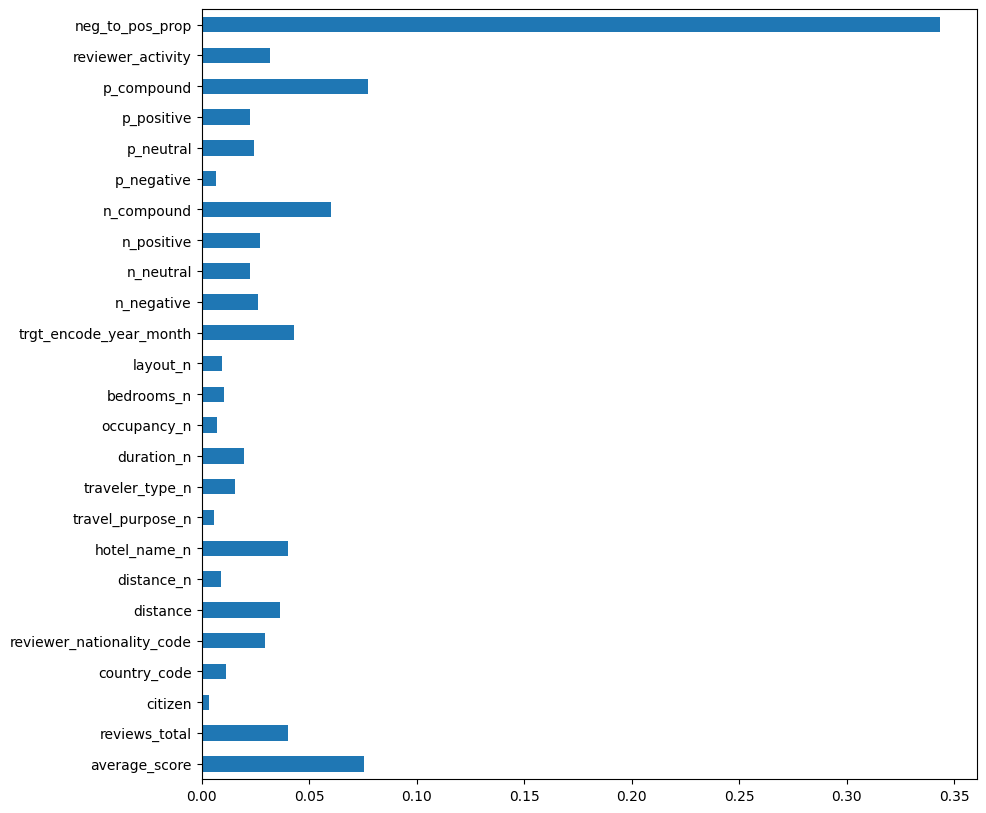

In [401]:
#rate the features for the model in terms of probable predictive importance
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh');

In [402]:
test_data.sample(10)

,average_score,reviews_total,reviewer_score,citizen,country_code,reviewer_nationality_code,distance,distance_n,hotel_name_n,travel_purpose_n,...,n_negative,n_neutral,n_positive,n_compound,p_negative,p_neutral,p_positive,p_compound,reviewer_activity,neg_to_pos_prop
171040,0.004586,0.302596,0.0,0.0,-0.924724,-0.105263,-1.102009,1.575739,-0.327459,0.43776,...,-0.539190,-1.580618,1.642095,1.009801,-0.302962,-1.619800,2.132693,0.469524,-0.460845,-0.762150
254727,0.551983,2.048471,0.0,1.0,0.806138,0.000000,-0.188892,-0.074825,-1.070924,0.43776,...,-0.539190,-1.580618,1.642095,1.009801,-0.302962,-0.186867,0.526717,0.892297,-0.191268,-0.762150
99221,1.099381,-0.788252,0.0,0.0,-2.078632,-2.105263,-0.846504,-1.175202,1.376316,0.43776,...,-0.539190,-1.580618,1.642095,1.009801,-0.302962,-0.172282,0.510371,0.022130,-0.460845,-0.762150
377548,-0.542812,-0.536252,0.0,0.0,-1.501678,0.052632,0.122013,0.475363,0.887311,0.43776,...,0.792293,0.530409,-0.733171,-0.737935,-0.302962,-0.890572,1.315402,0.395439,-0.460845,0.616185
394302,-0.542812,-1.026875,0.0,1.0,0.806138,0.000000,-0.443192,-0.074825,1.203726,0.43776,...,-0.539190,0.953628,-0.733171,-0.272531,-0.302962,0.688207,-0.454032,0.050743,-0.460845,-0.762150
141334,-0.360346,0.108419,0.0,1.0,0.806138,0.000000,-0.617562,-0.625013,-0.526601,0.43776,...,-0.539190,0.953628,-0.733171,-0.272531,-0.302962,0.159516,0.138504,0.517213,-0.191268,-0.762150
270393,-1.090210,1.286863,0.0,1.0,0.806138,0.000000,0.627061,0.475363,0.557619,0.43776,...,0.616888,0.586163,-0.733171,-0.681801,-0.302962,0.706437,-0.474465,0.374810,-0.460845,-0.762150
337184,0.004586,-0.149191,0.0,0.0,-1.501678,0.052632,-1.080400,1.575739,0.730210,0.43776,...,0.497294,0.487327,-0.604907,-1.369209,0.095043,-0.263436,0.195714,0.920467,-0.191268,-0.020055
100375,-0.542812,-0.655348,0.0,0.0,-2.078632,-1.000000,-1.103299,1.575739,0.845270,0.43776,...,-0.539190,-1.580618,1.642095,1.009801,-0.302962,-0.533250,0.914930,0.151002,1.102489,-0.762150
187515,-0.907744,-1.014361,0.0,0.0,-0.924724,-1.842105,-0.593971,-0.625013,1.068752,0.43776,...,2.115803,0.109724,-0.733171,-1.520125,-0.302962,-1.342693,1.822122,0.623904,0.783640,0.340518


In [403]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [404]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [405]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [406]:
predict_submission

array([7.962, 4.688, 6.717, ..., 9.423, 9.412, 8.935])

In [407]:
list(sample_submission)

['reviewer_score', 'id']

In [408]:
# sample_submission['reviewer_score'] = predict_submission
# sample_submission.to_csv('submission_for_competition.csv', index=False)
# sample_submission.head(10)